In [1]:
from load import load_all_sis_data

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping)

All data shape: (8, 63504, 6)
Element Mapping: {'C': 0, 'Fe': 1, 'He': 2, 'N': 3, 'O': 4, 'Si': 5}


The function below identifies periods of exponential decay in a given time series of flux data.

This function uses a sliding window approach, where a fixed-size window (specified by `window_size`) is moved across the logarithmic flux data. For each position of the window, linear regression is performed on the data within the window. The regression line's slope is computed, and if this slope is less than a predefined threshold (`slope_threshold`), it indicates a significant downward trend, characteristic of an exponential decay. The start and end times of the window are recorded as a decay segment if the slope condition is met.

After identifying all potential decay segments, it proceeds to merge overlapping or adjacent segments. This step ensures that a continuous decay period is not fragmented into multiple segments. The merging process checks if the start time of a new segment is within the current segment being considered. If the segments are close enough (considering the flux increase threshold), they are merged into a single continuous segment. This merging is done iteratively to cover all identified decay periods.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress

def identify_exponential_decays(flux_data, time_data, window_size, slope_threshold):
    """
    Args:
        flux_data (numpy.ndarray): Array of flux values.
        time_data (numpy.ndarray): Array of corresponding datetime values.
        window_size (int): Size of the sliding window for linear regression (in hours).
        slope_threshold (float): Threshold for the slope to identify a decay.

    Returns:
        list: List of tuples containing start and end times of decay segments.
    """
    # Make sure flux_data contains no zero or negative values
    flux_data = np.where(flux_data > 0, flux_data, np.nan)
    log_flux_data = np.log10(flux_data)
    #log_flux_data = gaussian_filter1d(log_flux_data, sigma=1)  # Smooth the data

    decays = []
    for i in range(len(log_flux_data) - window_size):
        window = log_flux_data[i:i + window_size]
        if np.isnan(window).any():
            continue
        slope, intercept, r_value, p_value, std_err = linregress(np.arange(window_size), window)

        if slope < slope_threshold:
            start_time = time_data[i]
            end_time = time_data[i + window_size - 1]
            decays.append((start_time, end_time))
    
    # Merge overlapping or adjacent decay segments
    merged_decays = []
    for start, end in decays:
        if merged_decays and start <= merged_decays[-1][1]:
            merged_decays[-1] = (merged_decays[-1][0], max(merged_decays[-1][1], end))
        else:
            merged_decays.append((start, end))
    
    return merged_decays


Code below finds and graphs events specific to each element, but since we want to use He as a reference for other elements it is not used at the moment

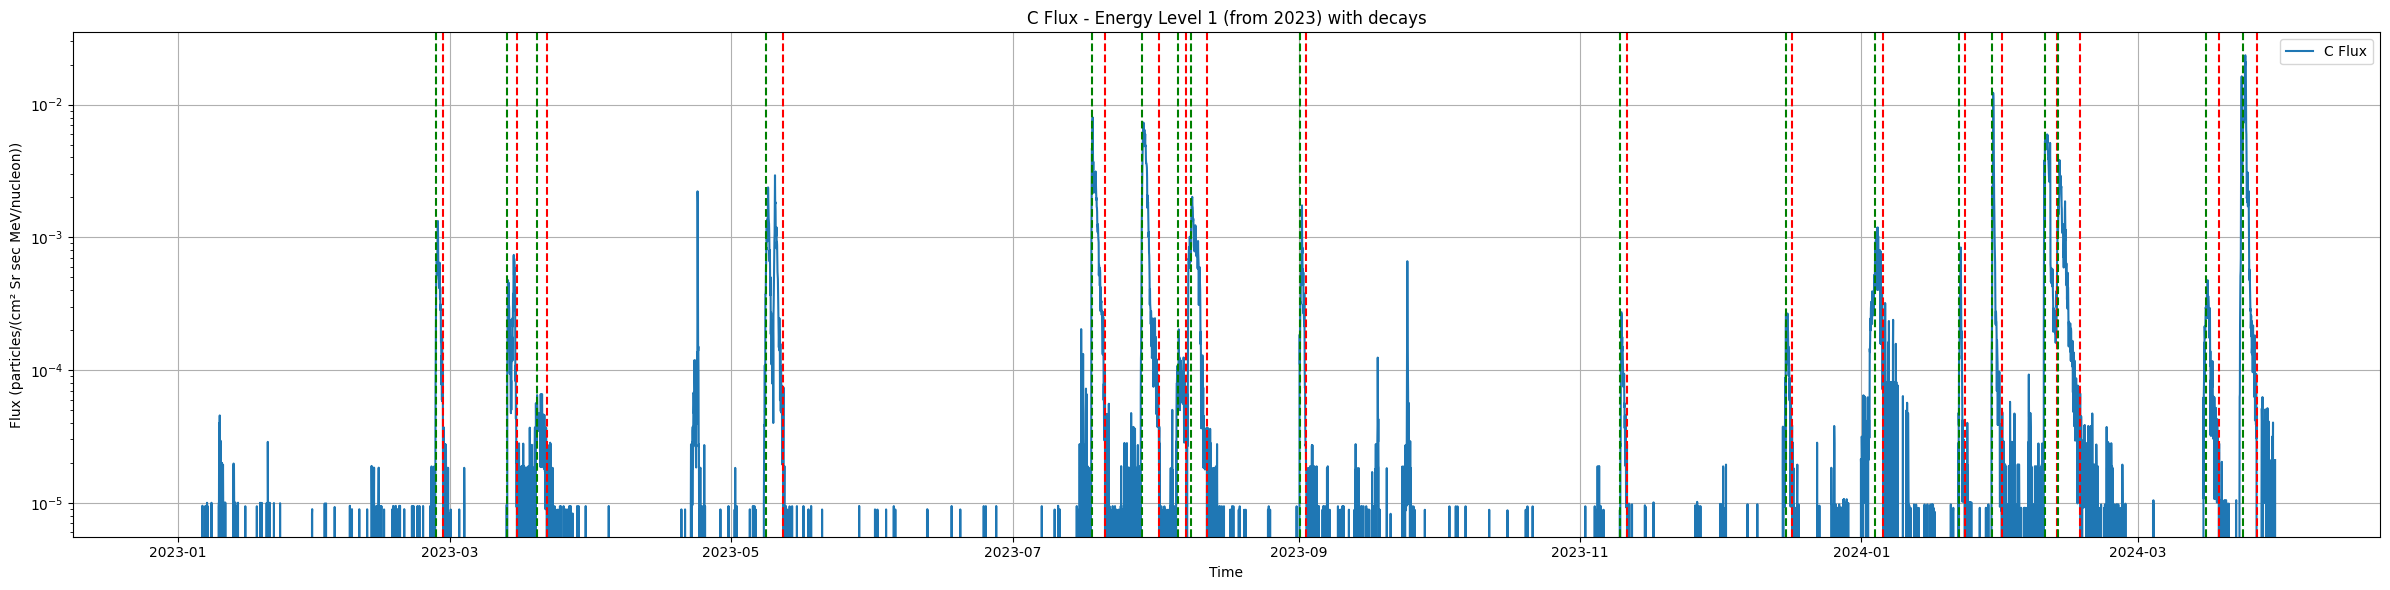

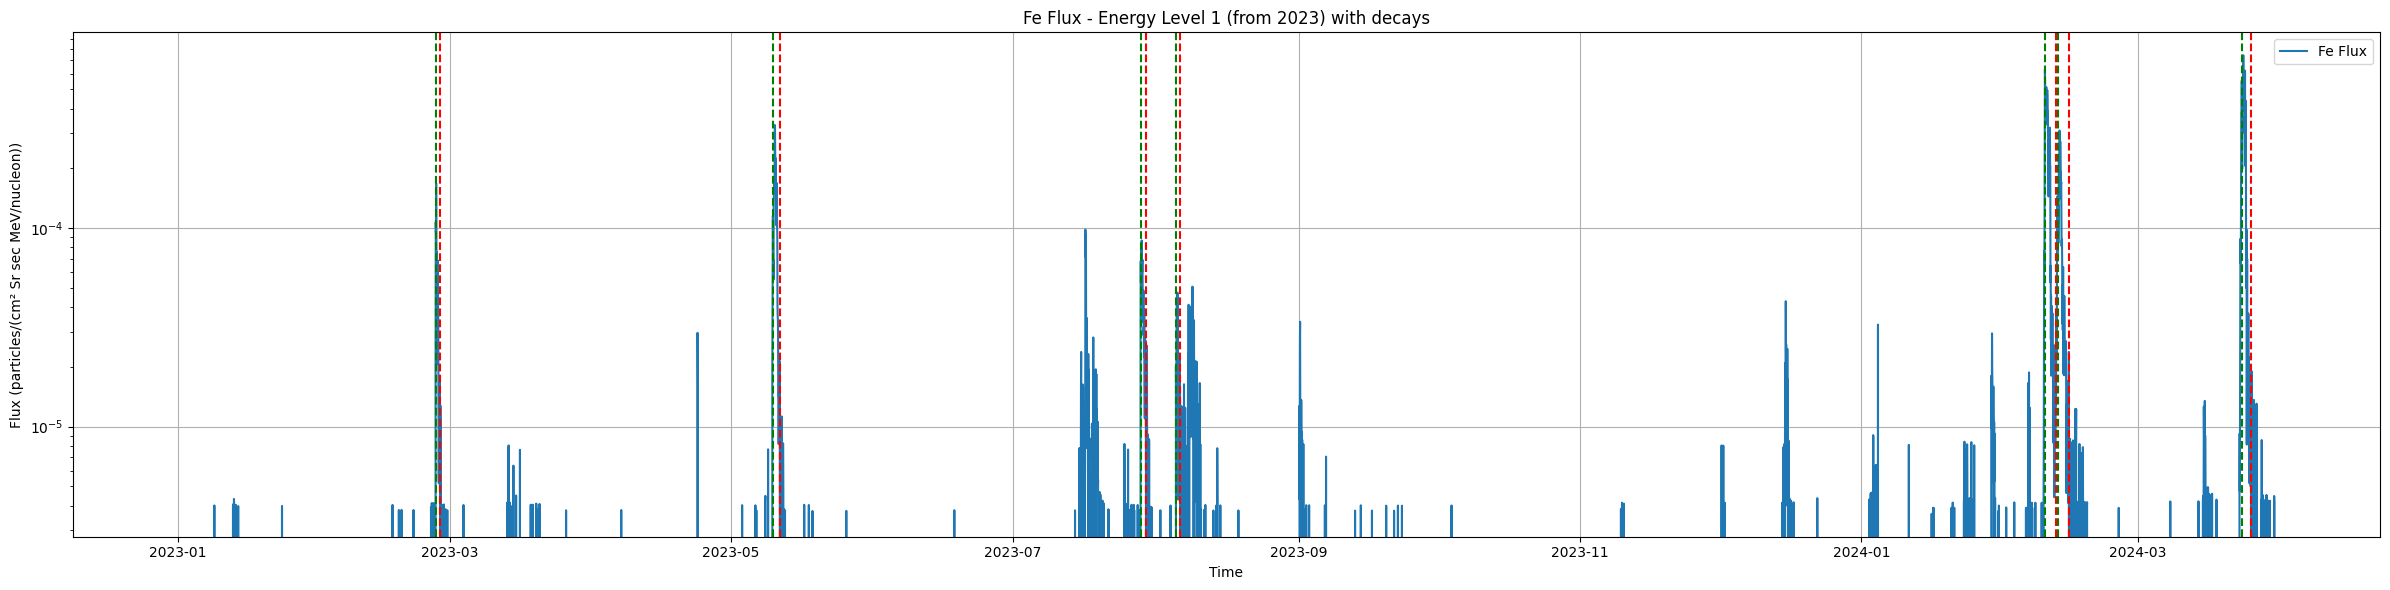

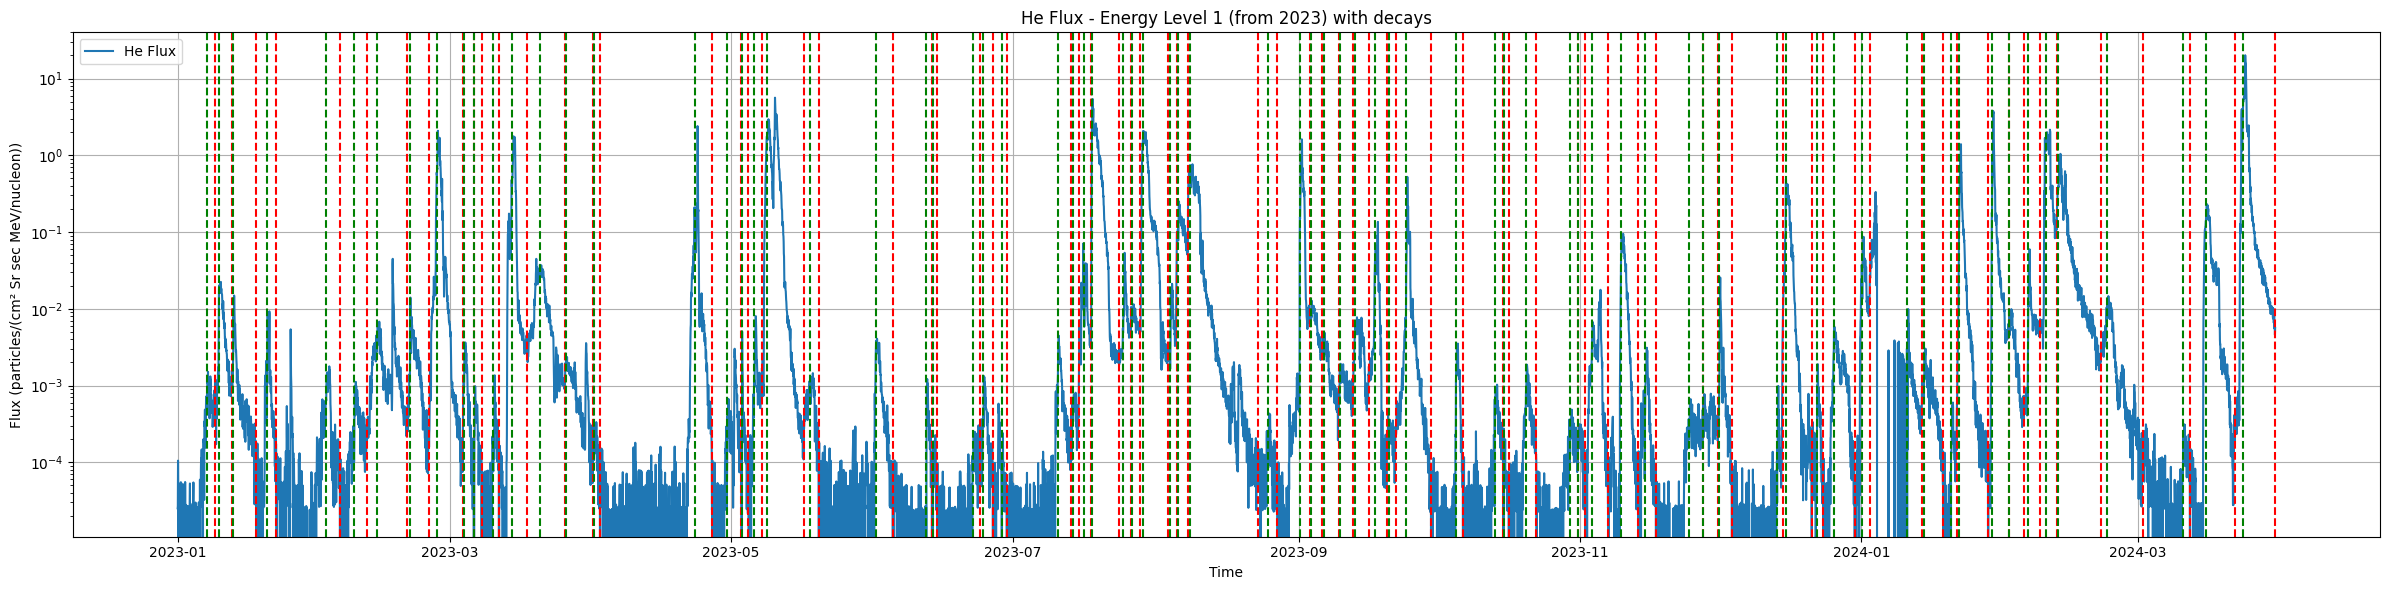

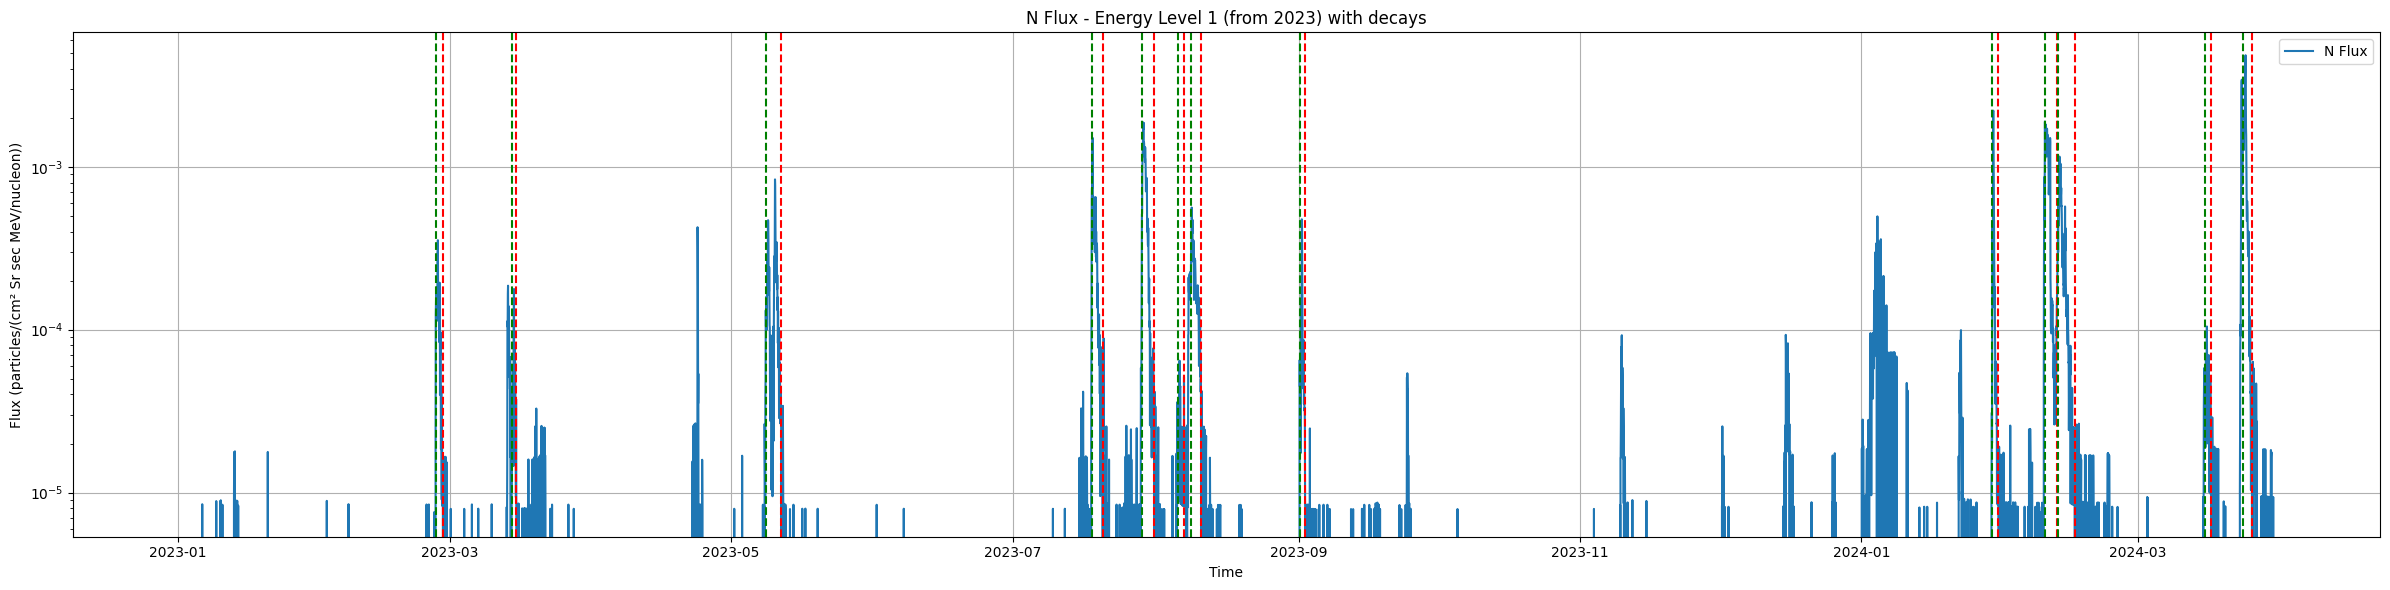

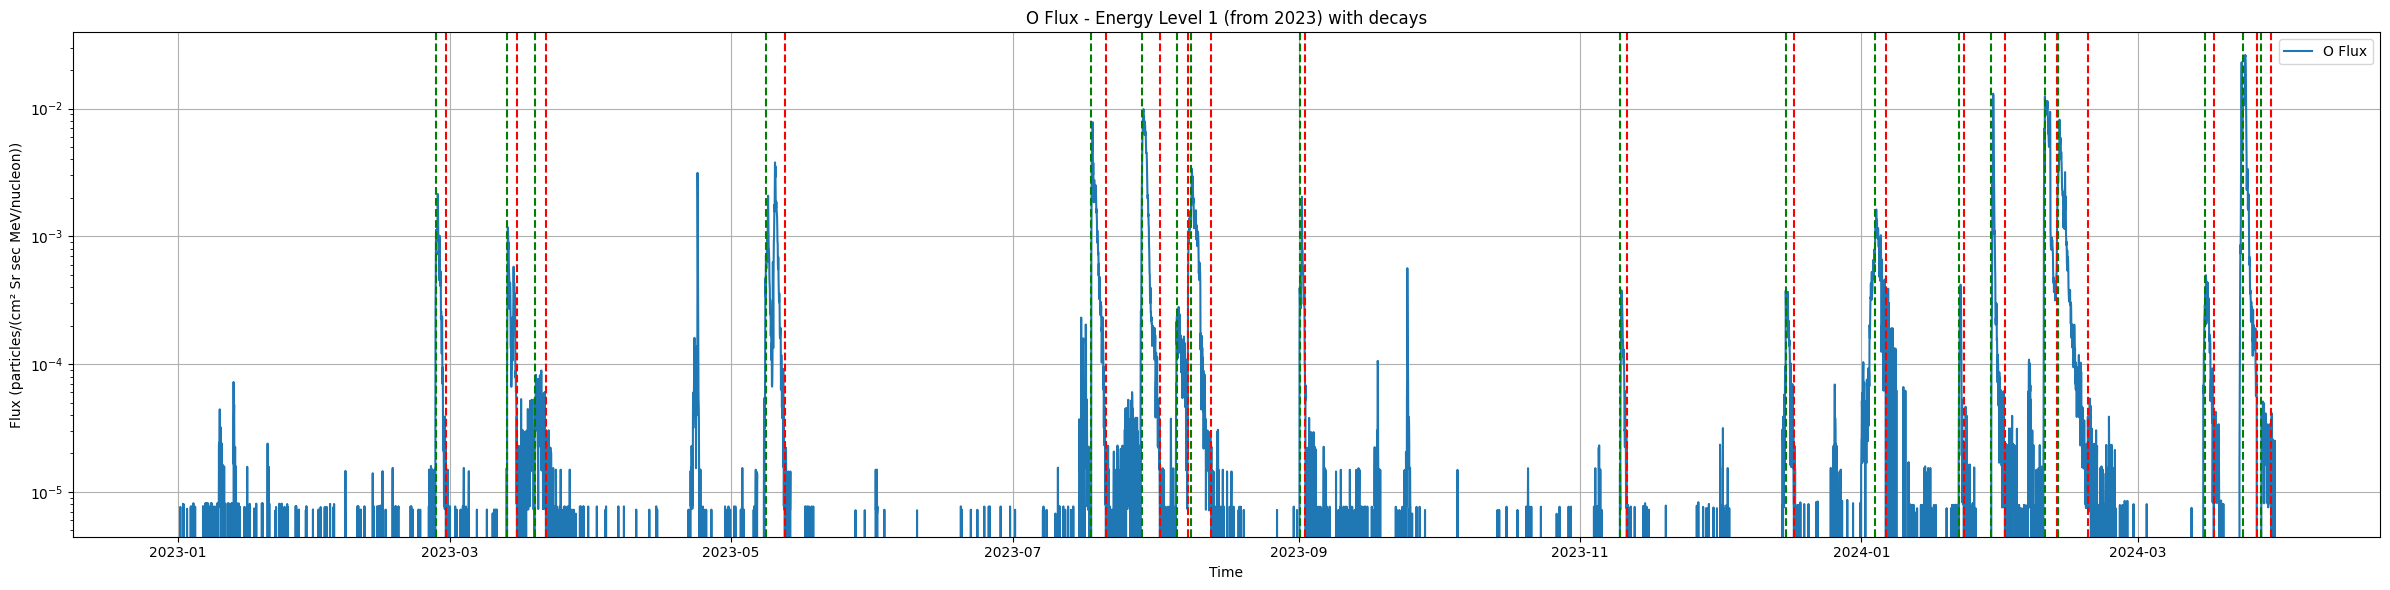

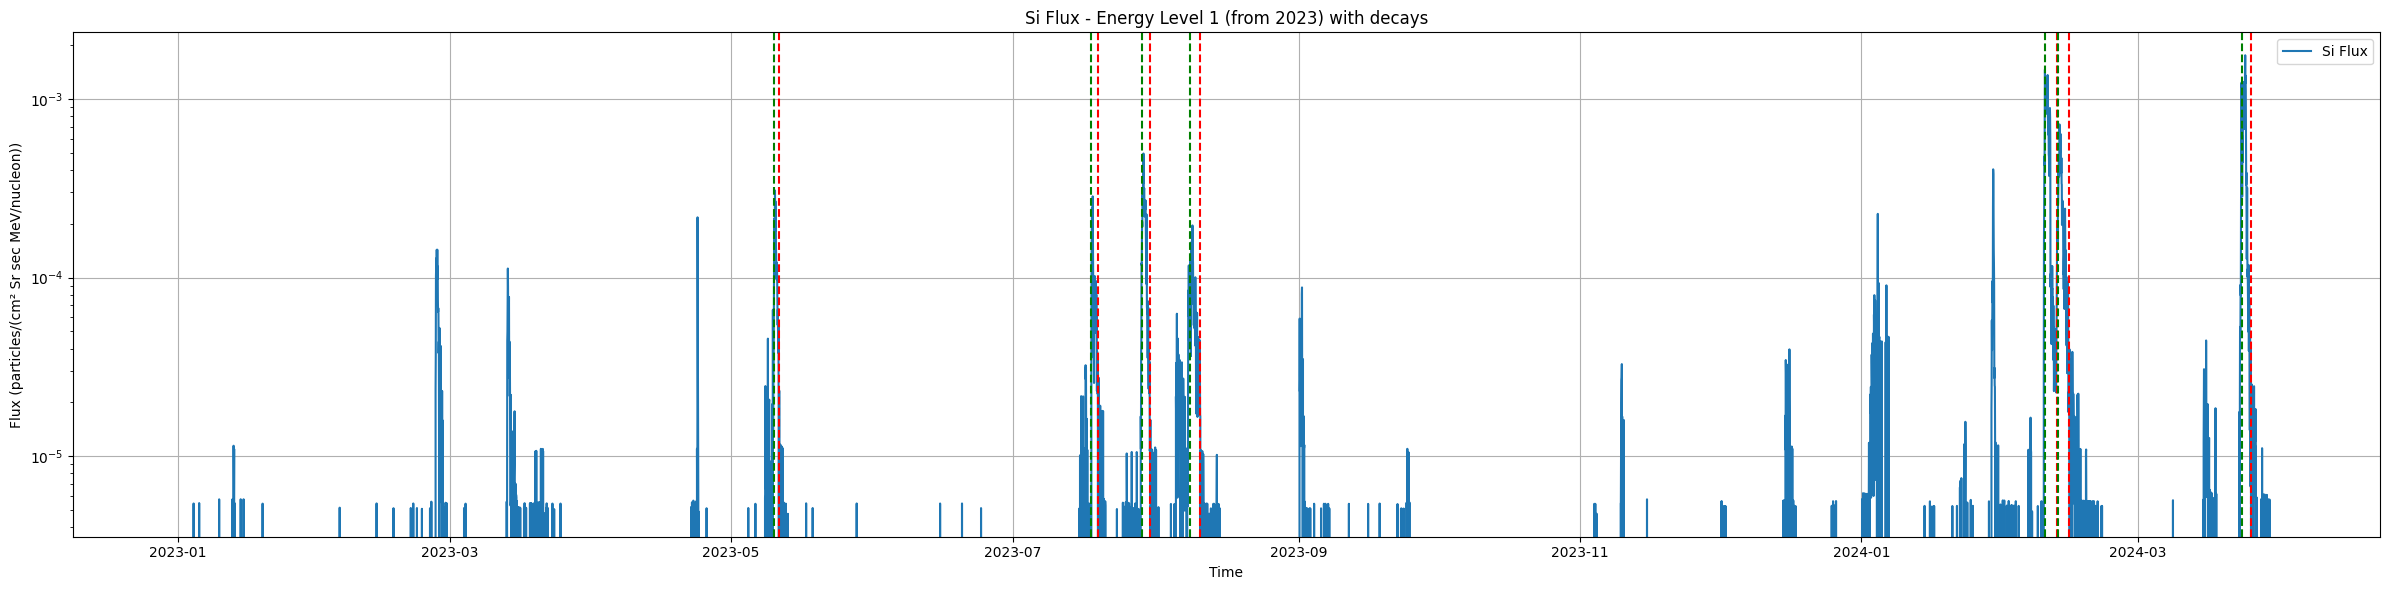

In [3]:
import pandas as pd


def calculate_noise_threshold_iqr(flux_data):
    """Calculates a noise threshold using q1, ignoring zeros and NaNs."""

    # Remove zeros and NaNs before calculating percentiles and IQR
    valid_flux_data = flux_data[np.logical_and(~np.isnan(flux_data), flux_data != 0)]

    if len(valid_flux_data) == 0:
        return 0 

    Q1 = np.percentile(valid_flux_data, 25)
    return Q1


def plot_element_fluxes_with_decays_and_stats(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time):
    """
    Plots separate graphs for flux data of each element at a specified energy level, 
    starting from a given year and omitting bad data. Includes statistical lines and decay segments.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to plot.
        start_time (datetime): Start time for the analysis window.
        end_time (datetime): End time for the analysis window.
    """
    
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6)) 

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        # Calculate statistics for the time window
        median_flux = np.median(element_flux)
        # std_flux = np.std(element_flux)
        # noise_cutoff = median_flux + 2 * std_flux  


        plt.plot(element_time, element_flux, label=f'{element_name} Flux')
        plt.yscale('log')

        # Identify exponential decay segments
        decay_segments = identify_exponential_decays(element_flux, element_time, window_size=24, slope_threshold=-0.005)

        for start, end in decay_segments:
            plt.axvline(start, color='g', linestyle='--', label='_nolegend_')
            plt.axvline(end, color='r', linestyle='--', label='_nolegend_')

        # noise_threshold = calculate_noise_threshold_iqr(element_flux)
        # plt.axhline(noise_threshold, color='y', linestyle='-', label='Noise Threshold (IQR)')
        # print(noise_threshold)

        # plt.axhline(median_flux, color='y', linestyle='--', label='Median')
        # print(median_flux)
        # plt.axhline(median_flux + std_flux, color='g', linestyle='-.', label='Median + STD')
        # plt.axhline(noise_cutoff, color='b', linestyle=':', label='Noise Cutoff (2*STD)')

        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))') 
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year}) with decays')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Example usage
energy_level_to_plot = 1
start_time = pd.to_datetime('2023-01-01')
end_time = pd.to_datetime('2024-04-01')
plot_element_fluxes_with_decays_and_stats(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, start_time, end_time)


Code below graphs all elements with helium as reference within a certain energy level. For example, if the `energy_level` input of the function is set to 2, then decays are identified based on Helium's flux data over the specified period of time at energy 2, and those windows are applied to the other elements at energy level 2.

Number of helium decay events found: 9


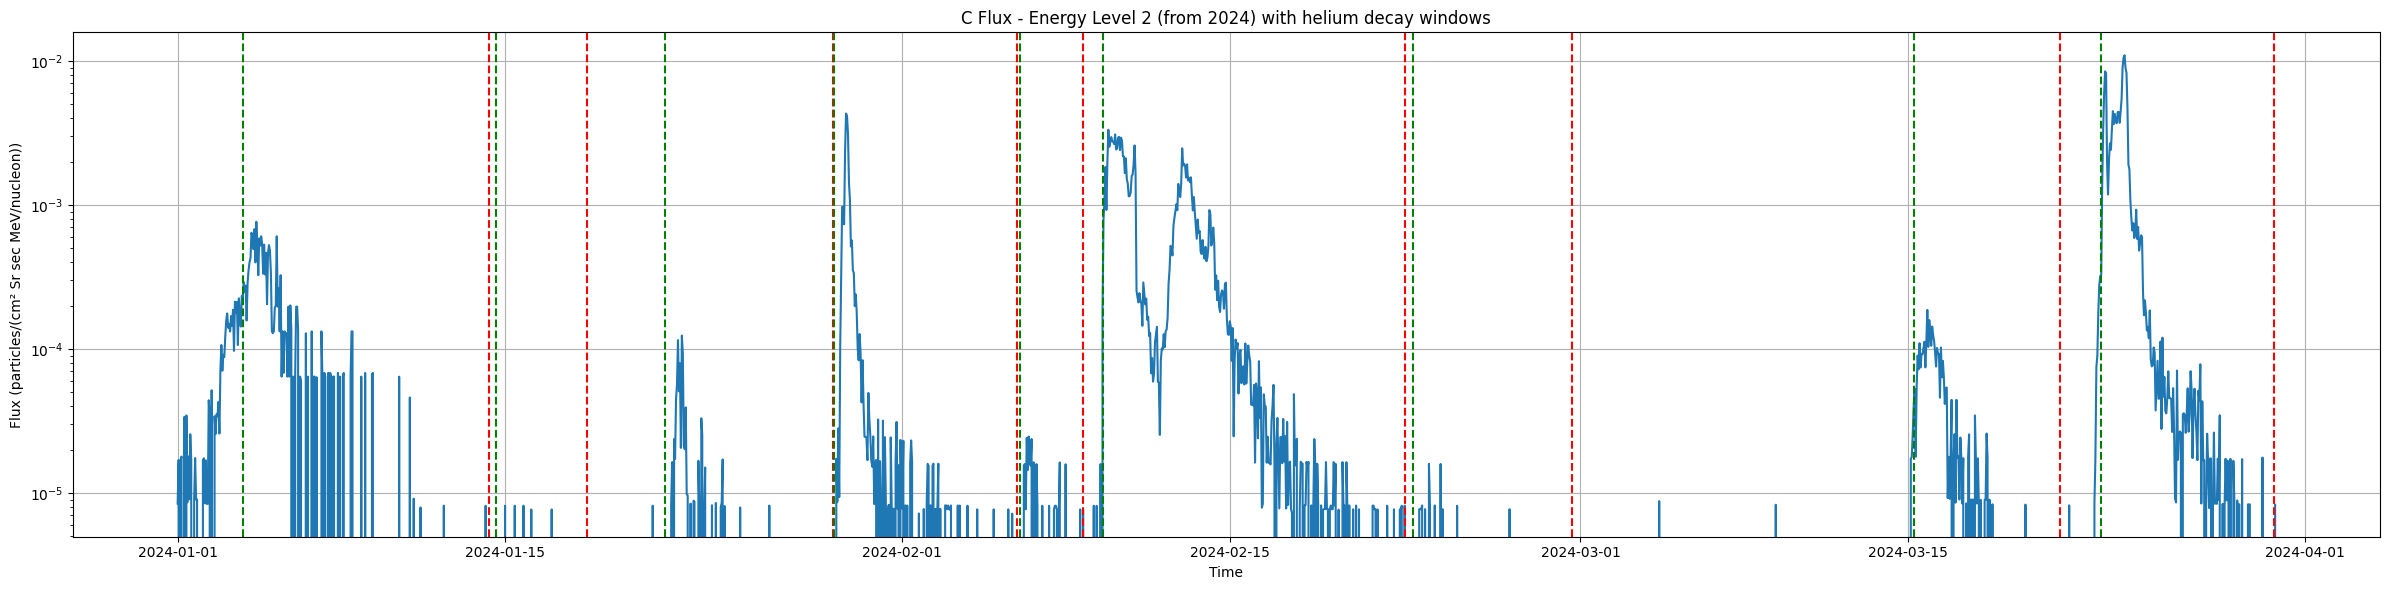

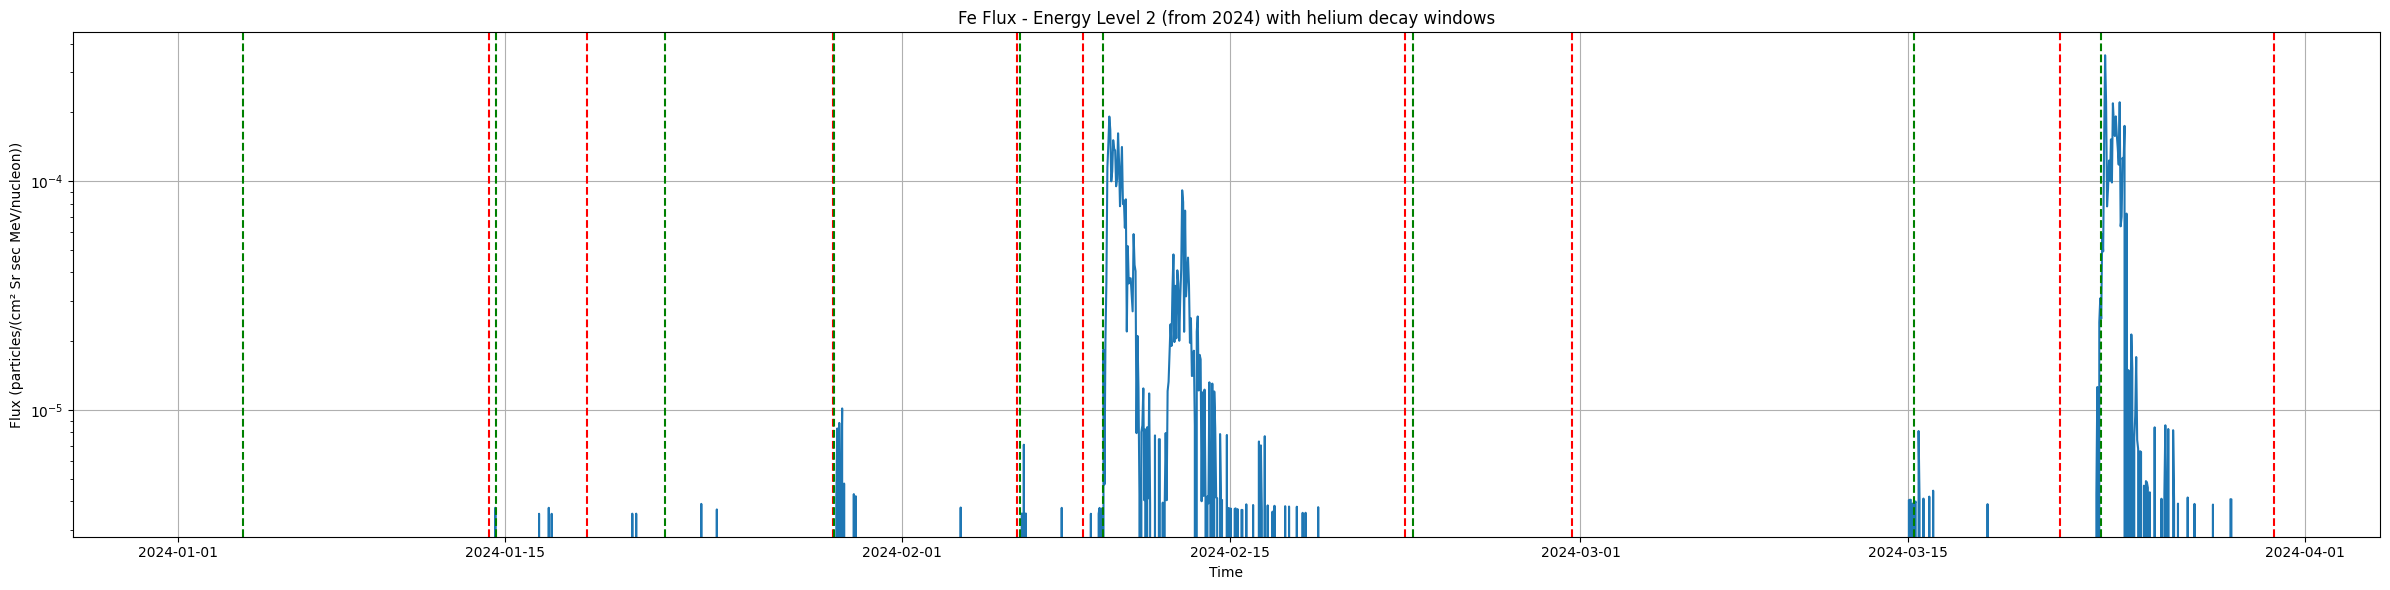

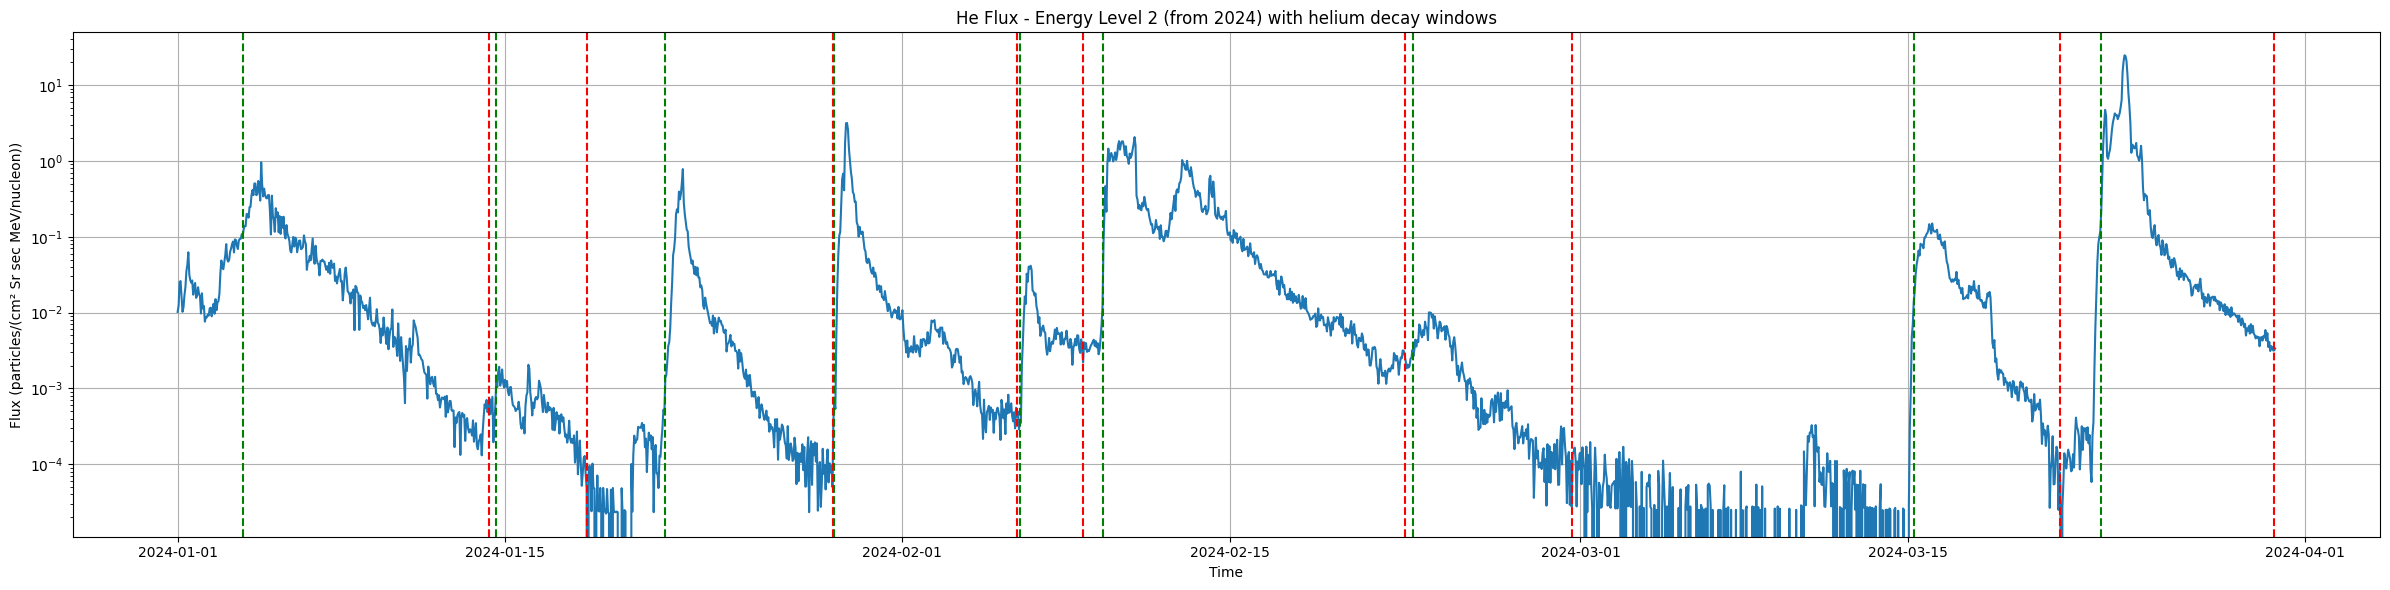

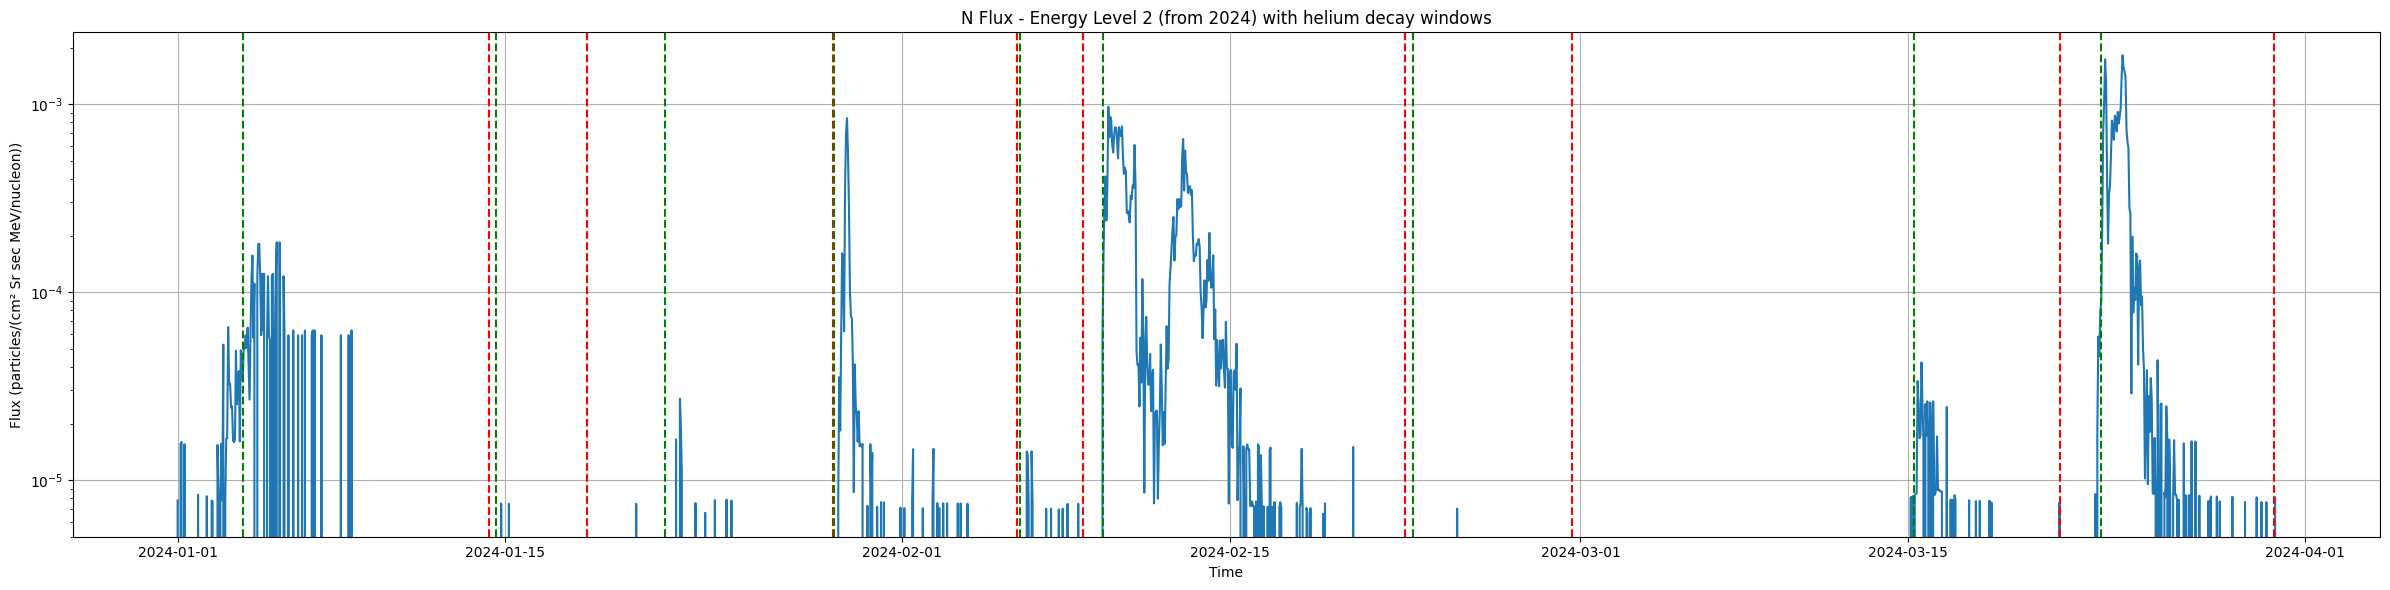

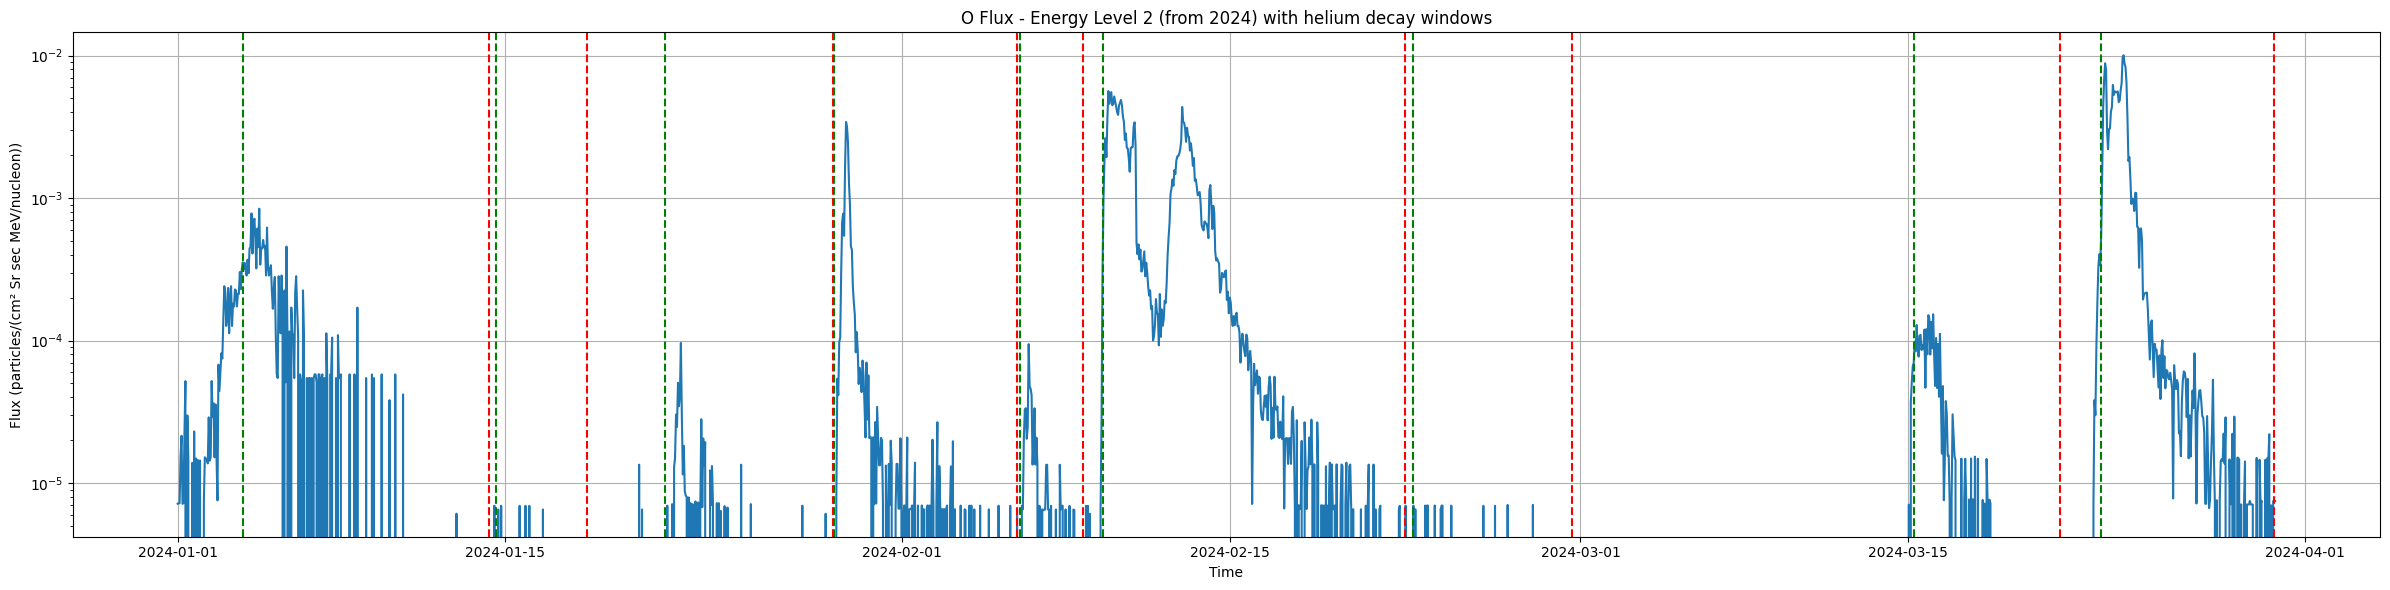

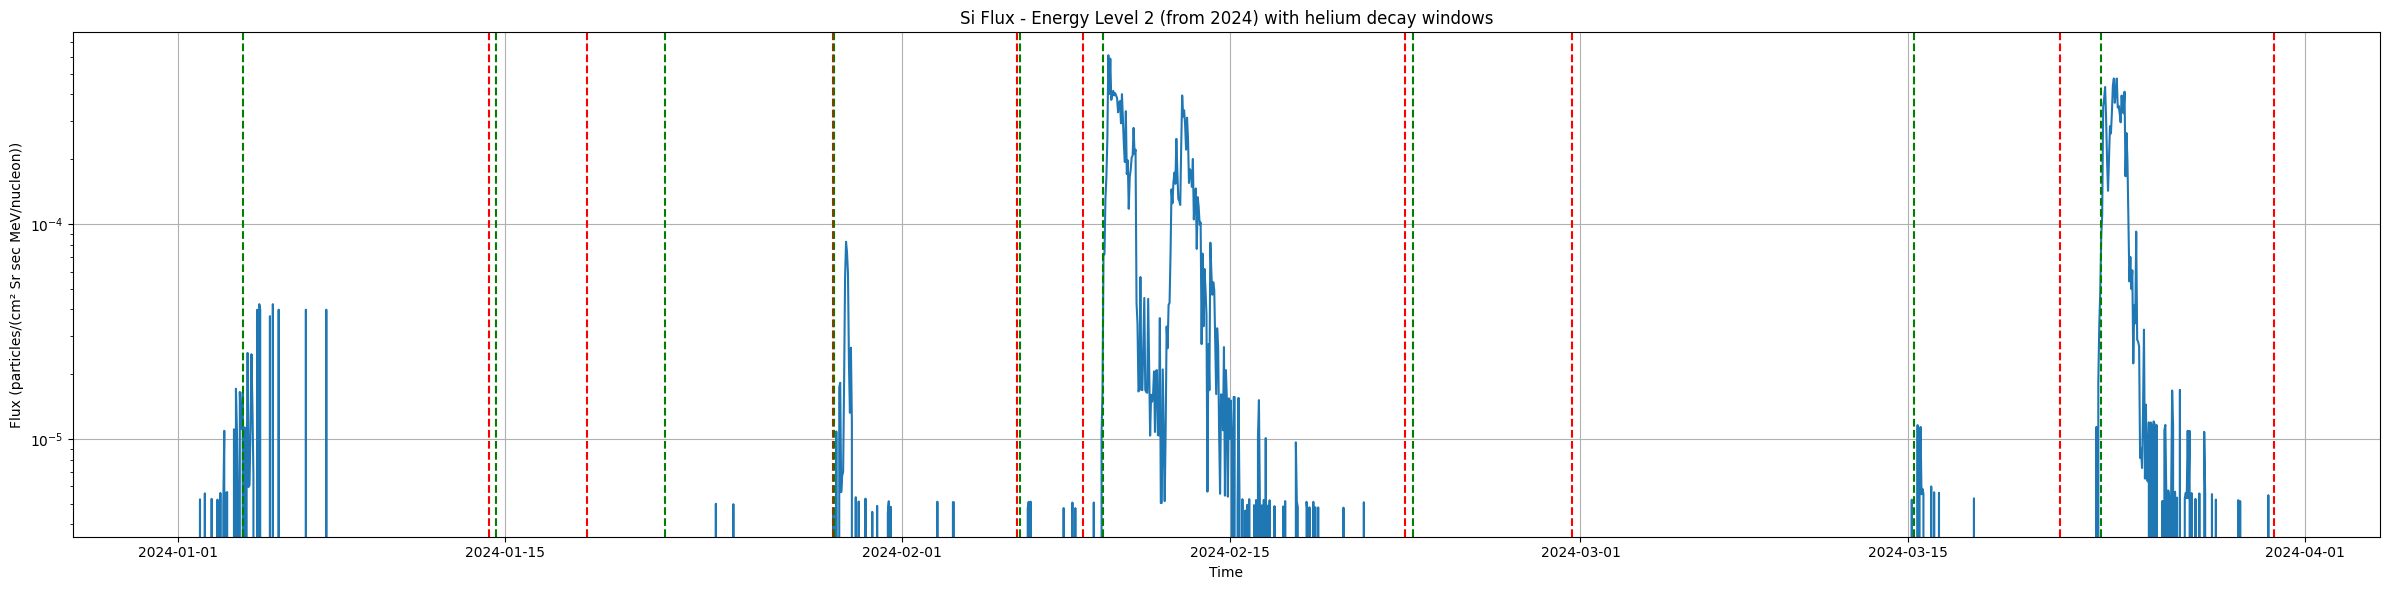

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_fluxes_with_helium_windows(data_3d, datetime_values, element_mapping, energy_level, start_time, end_time):
    
    time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

    helium_index = element_mapping['He']
    helium_flux = data_3d[energy_level - 1, time_mask, helium_index]

    # Omit bad data points for helium
    valid_data_mask = helium_flux != -999.9
    helium_flux = helium_flux[valid_data_mask]
    helium_time = datetime_values[time_mask][valid_data_mask]

    if len(helium_flux) == 0:
        print("No valid helium data in the specified time range.")
        return
    
    # # Calculate Q1 and filter helium_flux and helium_time 
    # Q1 = np.percentile(helium_flux, 25) 
    # q1_mask = helium_flux >= Q1
    # filtered_helium_flux = helium_flux[q1_mask]
    # filtered_helium_time = helium_time[q1_mask]

    
    # # Calculate statistics for the time window
    # # median_flux = np.median(element_flux)
    # # std_flux = np.std(element_flux)
    # # noise_cutoff = median_flux + 2 * std_flux  

    # # plt.axhline(median_flux, color='r', linestyle='--', label='Median')
    # # plt.axhline(median_flux + std_flux, color='g', linestyle='-.', label='Median + STD')
    # # plt.axhline(noise_cutoff, color='b', linestyle=':', label='Noise Cutoff (2*STD)')

    # Identify exponential decay segments in helium data
    decay_segments = identify_exponential_decays(helium_flux, helium_time, window_size=48, slope_threshold=-0.005)
    #decay_segments = identify_exponential_decays(filtered_helium_flux, filtered_helium_time)
    #print(decay_segments)

    # Print the number of decay events found
    print(f'Number of helium decay events found: {len(decay_segments)}')
    
    # Plot the flux data for each element during the helium decay windows
    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(24, 6))

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        if len(element_flux) == 0:
            continue

        plt.plot(element_time, element_flux, label=f'{element_name} Flux')
        plt.yscale('log')

        for start, end in decay_segments:
            plt.axvline(start, color='g', linestyle='--', label='Decay start')
            plt.axvline(end, color='r', linestyle='--', label='Decay end')

        plt.xlabel('Time')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))')
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_time.year}) with helium decay windows')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example data and parameters (use your actual data here)
energy_level_to_plot = 2
# start_time = pd.to_datetime('2024-03-24')
# end_time = pd.to_datetime('2024-03-30')

# start_time = pd.to_datetime('2018-3-01')
# end_time = pd.to_datetime('2018-3-30')

start_time = pd.to_datetime('2024-01-01')
end_time = pd.to_datetime('2024-4-30')


# Run the plot function with helium windows
plot_fluxes_with_helium_windows(all_flux_data, datetime_values, element_mapping, energy_level_to_plot, start_time, end_time)

Code below uses the `identify_exponential_decays` function defined above to find decay events within the entire data range (2017 to 2024 day 90) based on Helium flux at an energy level defined by `energy_level_to_compute`. The computed event windows are then stored in a Pandas dataframe. Keeps only events that are longer than 48 hours **and** where the helium (reference) flux stays above the threshold for the specified duration, then disregards the rest.

Raising the `he_flux_threshold` will result in only more significant events being kept.

In [5]:
import numpy as np
import pandas as pd

def compute_decay_events_for_all_data(data_3d, datetime_values, element_mapping, energy_level, he_flux_threshold, min_duration_hours):
    """
    Computes decay events for all available data, keeping only events where 
    helium flux stays above the threshold for the specified duration.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects.
        element_mapping (dict): Element name to array index mapping.
        energy_level (int): The energy level to analyze.
        flux_threshold (float): Minimum helium flux threshold.
        min_duration_hours (int): Minimum duration (hours) above threshold.

    Returns:
        pd.DataFrame: DataFrame with decay event details.
    """
    helium_index = element_mapping['He']
    helium_flux = data_3d[energy_level - 1, :, helium_index]

    valid_data_mask = helium_flux != -999.9
    helium_flux = helium_flux[valid_data_mask]
    helium_time = datetime_values[valid_data_mask]

    if len(helium_flux) == 0:
        print("No valid helium data available.")
        return pd.DataFrame()

    decay_segments = identify_exponential_decays(helium_flux, helium_time, window_size=24, slope_threshold=-0.005)
    decay_event_details = []

    for event_number, (start, end) in enumerate(decay_segments):
        # Find indices corresponding to start and end times
        start_index = np.where(helium_time == start)[0][0]
        end_index = np.where(helium_time == end)[0][0]

        # Find periods where helium flux is above the threshold
        above_threshold_mask = helium_flux[start_index:end_index] >= he_flux_threshold
        above_threshold_times = helium_time[start_index:end_index][above_threshold_mask]

        # Calculate the duration of continuous periods above the threshold
        duration_above_threshold = 0
        if len(above_threshold_times) > 1:
            time_differences = np.diff(above_threshold_times)
            # Consider gaps of 1 hour or less as continuous
            continuous_periods = np.where(time_differences <= pd.Timedelta(hours=1))[0]
            if len(continuous_periods) > 0:
                duration_above_threshold = (
                    above_threshold_times[continuous_periods[-1] + 1] - above_threshold_times[0]
                ).total_seconds() / 3600

        # Keep events where the duration above threshold is long enough
        if duration_above_threshold >= min_duration_hours:
            start_year = start.year
            end_year = end.year
            start_frac_day = (
                start.timetuple().tm_yday
                + start.hour / 24
                + start.minute / 1440
                + start.second / 86400
            )
            end_frac_day = (
                end.timetuple().tm_yday
                + end.hour / 24
                + end.minute / 1440
                + end.second / 86400
            )
            start_hour = start.hour + start.minute / 60 + start.second / 3600
            end_hour = end.hour + end.minute / 60 + end.second / 3600

            decay_event_details.append(
                {
                    "Event Number": event_number + 1,
                    "Start Year": start_year,
                    "End Year": end_year,
                    "Start Fractional Day": start_frac_day,
                    "End Fractional Day": end_frac_day,
                    "Start Hour": start_hour,
                    "End Hour": end_hour,
                }
            )

    decay_events_df = pd.DataFrame(decay_event_details)

    return decay_events_df


energy_level_to_compute = 1
he_flux_threshold = 1e-4
min_duration_hours = 48
decay_events_df = compute_decay_events_for_all_data(all_flux_data, datetime_values, element_mapping, energy_level_to_compute, he_flux_threshold, min_duration_hours)

# Fix columns from wrwapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')

print(decay_events_df)
decay_events_df.to_csv('out_csv/uncleaned_decay_events.csv', index=False)

     Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour 
0           2         2017       2017           5.999988            10.208322       23.999722   4.999722
1           4         2017       2017          12.958333            18.375000       23.000000   9.000000
2           5         2017       2017          31.874988            34.083333       20.999722   2.000000
3           8         2017       2017          39.625000            43.958322       15.000000  22.999722
4          11         2017       2017          92.041655            97.333322        0.999722   7.999722
..            ...         ...       ...                   ...                 ...         ...        ...
99        182         2024       2024          41.098472            43.466979        2.363333  11.207500
100       183         2024       2024          43.716296            52.982569       17.191111  23.581667
101       184         2024       2024          54.31226

Code below plots all the identified decay events in a grid, each plot showing fluxes of all elements,
    with formatted x-axis ticks showing day of year, and includes 1 day before/after each event
    separated by vertical lines.

Graph of flux events using data from energy level 1 and using data from Helium at energy level 1 for cutoffs


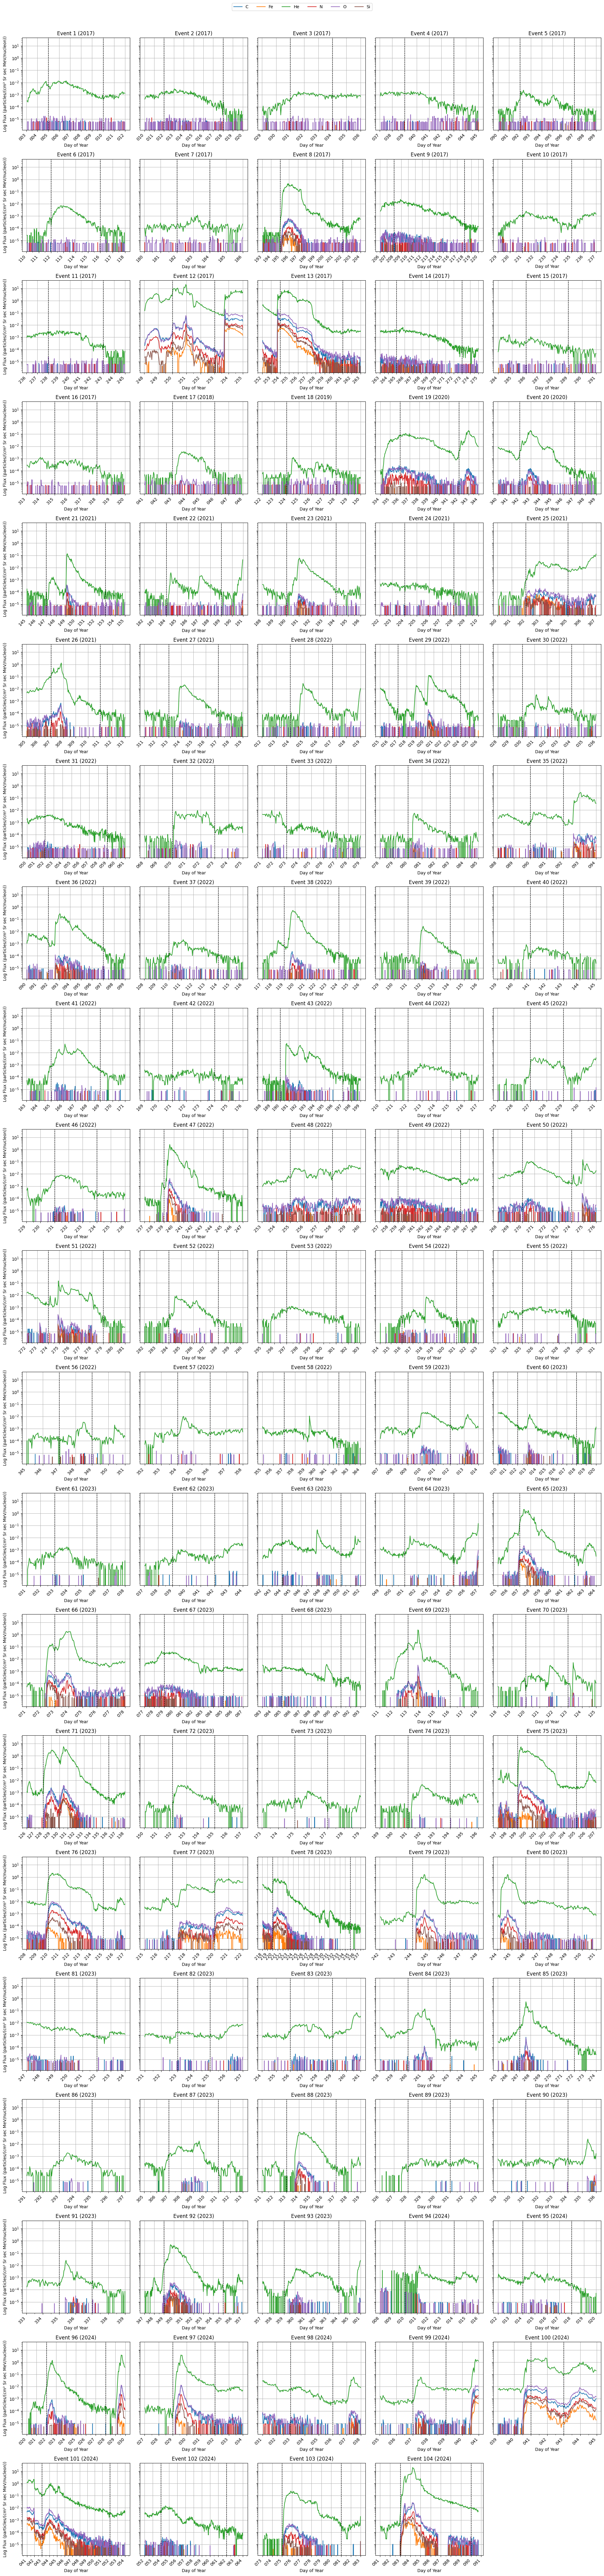

In [6]:
from graph import plot_all_decay_events

energy_level_to_plot = 1
extend_days = 2  # Adjust the number of days to extend before and after
print(f"Graph of flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_compute} for cutoffs")
plot_all_decay_events(decay_events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, True)

    Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour 
0         16         2017       2017         195.666655           200.375000       15.999722   9.000000
1         17         2017       2017         208.666655           218.791667       15.999722  19.000000
2         22         2017       2017         250.499988           253.508333       11.999722  17.000000
3         23         2017       2017         253.833333           261.166667        8.000000   4.000000
4         25         2017       2017         265.416655           273.958322        9.999722  22.999722
5         44         2020       2020         336.248171           342.065567        5.956111   1.573611
6         45         2020       2020         342.647303           347.176562       15.535278   4.237500
7         47         2021       2021         149.049988           153.999988        5.999722  23.999722
8         51         2021       2021         190.875000         

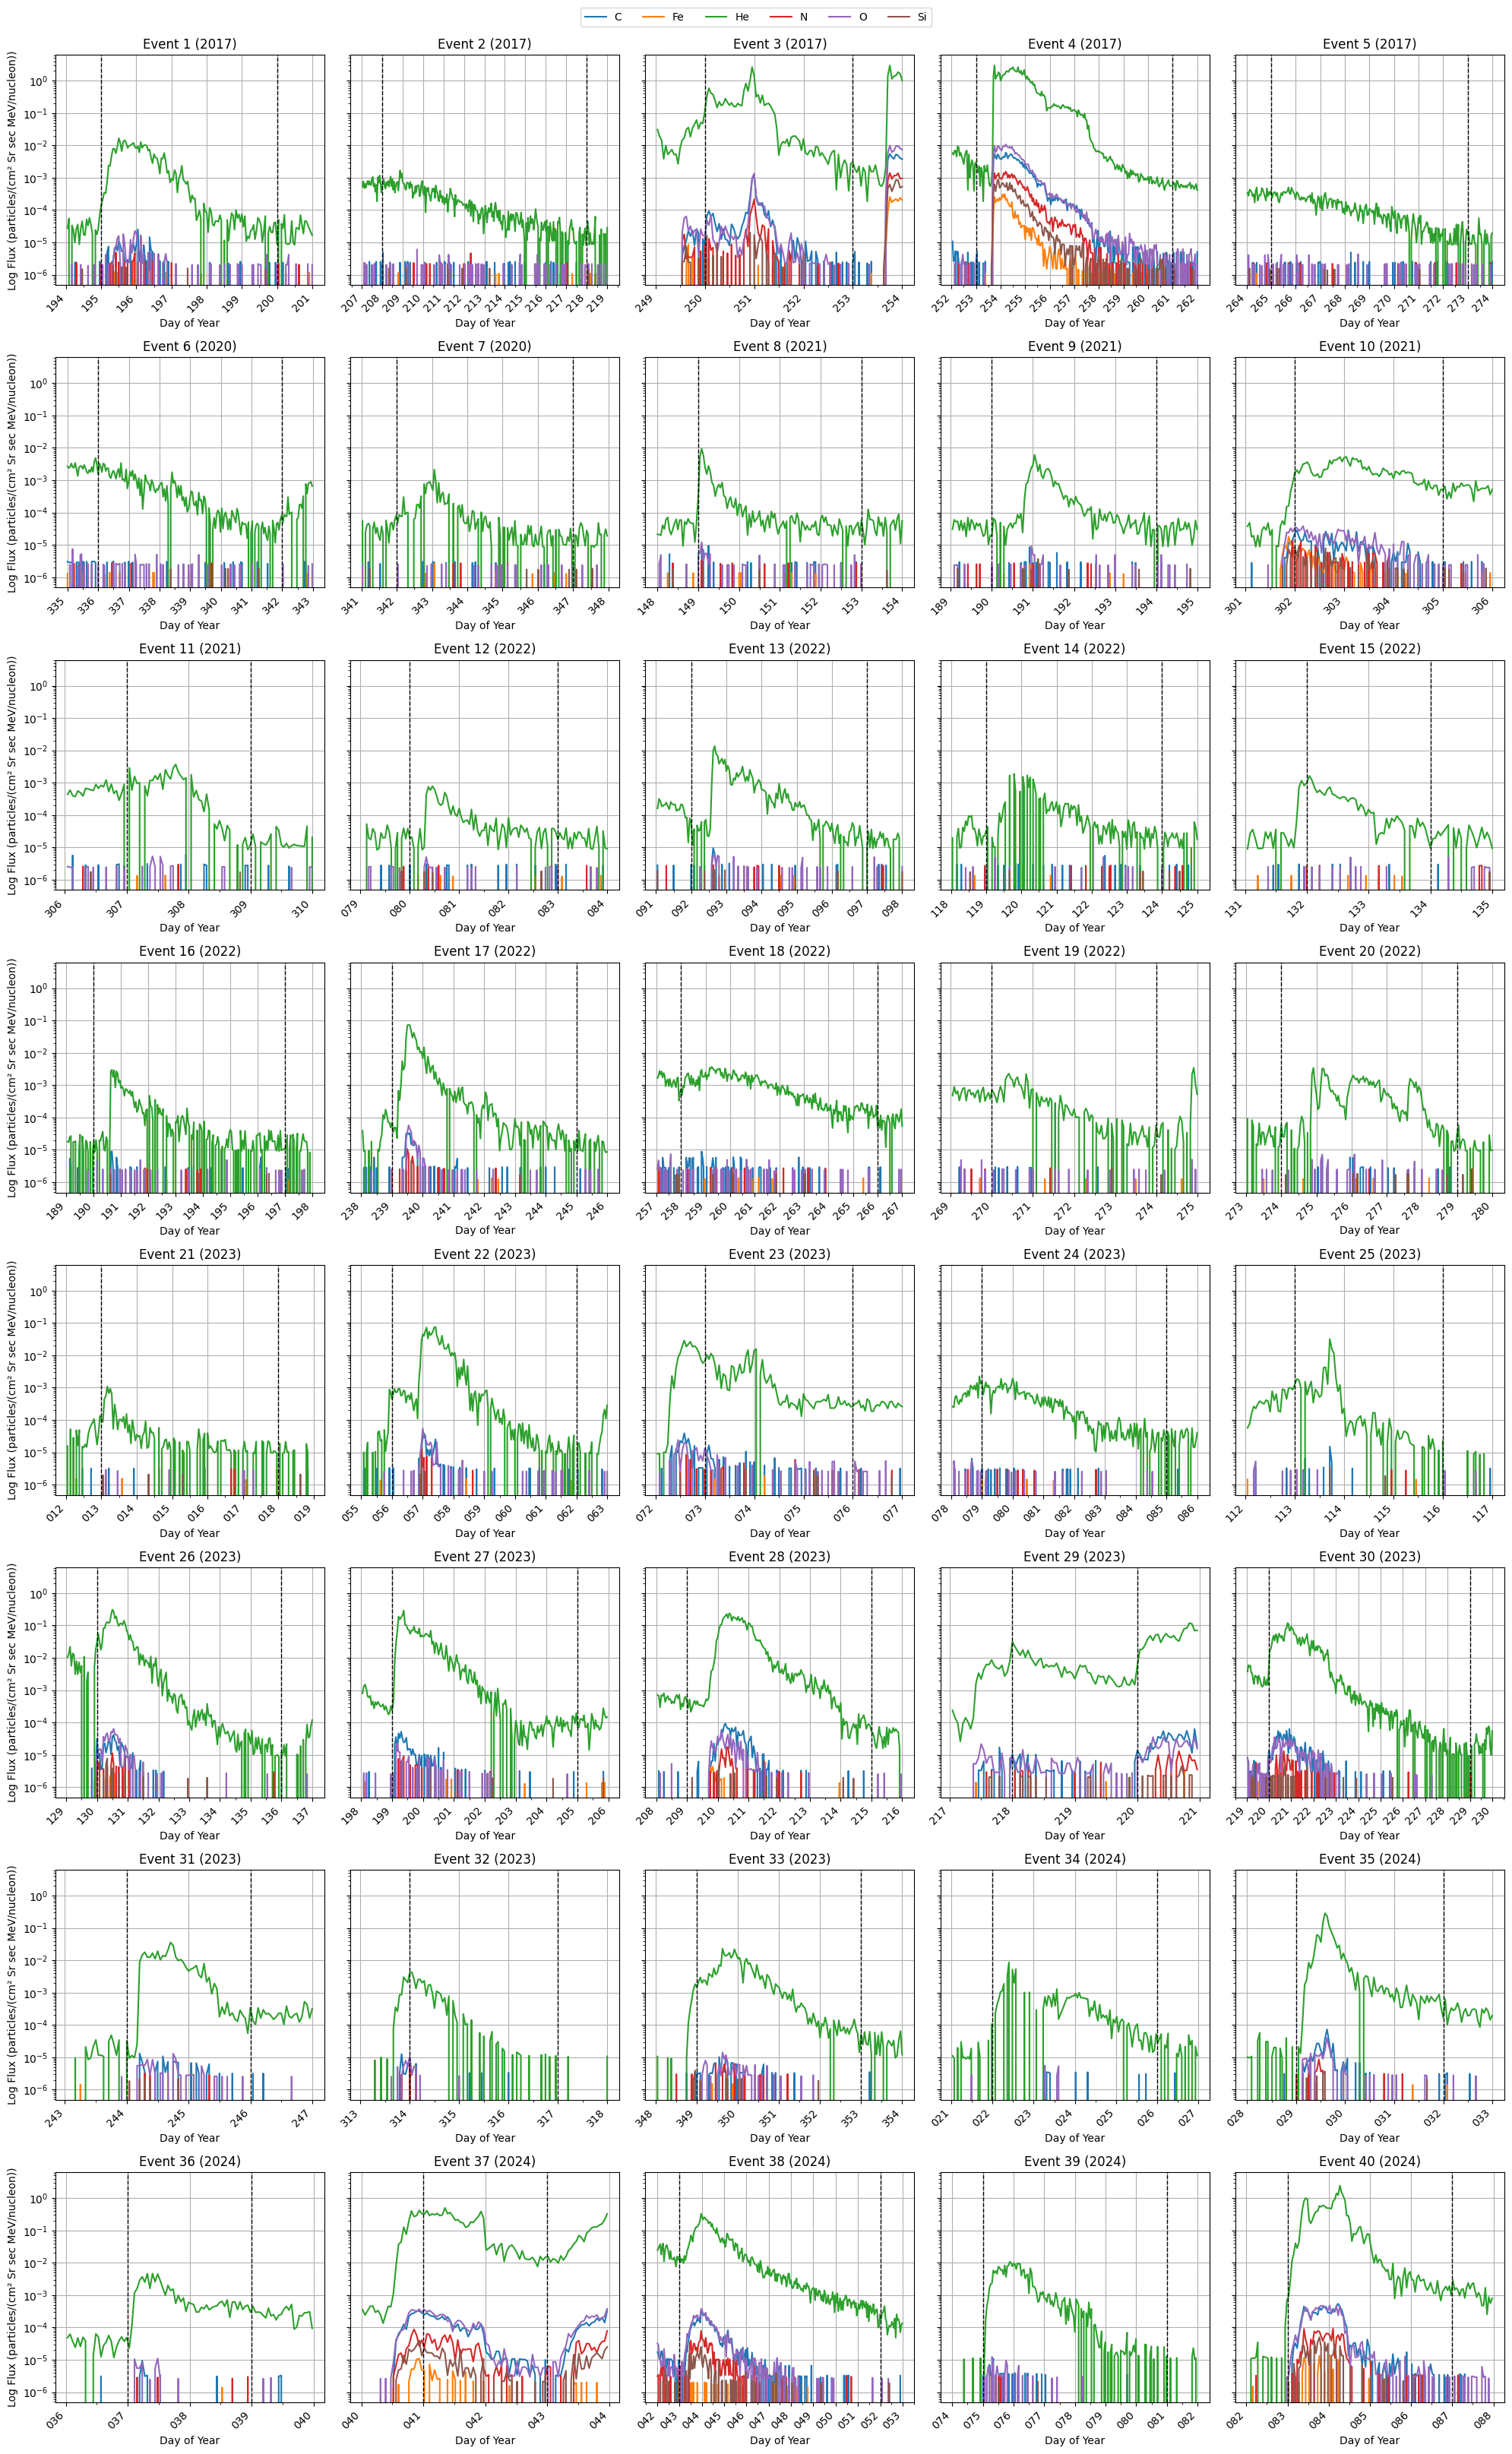

In [7]:
import pandas as pd
from graph import plot_all_decay_events

def process_decay_events(decay_events_file, manual_trim_file):
    decay_events_df = pd.read_csv(decay_events_file)

    # Load trim instructions into a list
    with open(manual_trim_file, 'r') as f:
        manual_trim = [line.strip() for line in f if line.strip()]


    indices_to_keep = set()
    for instruction in manual_trim:
        parts = instruction.split(',')
        index = int(parts[0]) - 1  # Convert 1-based index to 0-based
        indices_to_keep.add(index)

        if len(parts) > 1:
            operation = parts[1].strip()
            value = float(parts[2].strip())

            if operation == 'shorten back':
                decay_events_df.at[index, 'End Fractional Day'] -= value
            elif operation == 'lengthen back':
                decay_events_df.at[index, 'End Fractional Day'] += value
            elif operation == 'shorten front':
                decay_events_df.at[index, 'Start Fractional Day'] += value
            elif operation == 'lengthen front':
                decay_events_df.at[index, 'Start Fractional Day'] -= value

    decay_events_df = decay_events_df.loc[list(indices_to_keep)].reset_index(drop=True)
    return decay_events_df

decay_events_file = 'out_csv/uncleaned_decay_events.csv'
manual_trim_file = 'manual_trim.txt'
cleaned_decay_events_df = process_decay_events(decay_events_file, manual_trim_file)
decay_events_df.to_csv('out_csv/cleaned_decay_events.csv', index=False)
print(cleaned_decay_events_df)

energy_level_to_plot = 5
extend_days = 1
useLogScale = True
print(f"Graph of cleaned flux events using data from energy level {energy_level_to_plot} and using data from Helium at energy level {energy_level_to_plot} for cutoffs")
plot_all_decay_events(cleaned_decay_events_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, useLogScale)


    Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour 
0         16         2017       2017         195.666655           200.375000       15.999722   9.000000
1         22         2017       2017         250.499988           253.508333       11.999722  17.000000
2         23         2017       2017         253.833333           261.166667        8.000000   4.000000
3         62         2021       2021         302.666667           305.541655       16.000000  12.999722
4         96         2022       2022         239.416667           245.833333       10.000000  20.000000
5        119         2023       2023          56.666667            62.875000        4.000000  21.000000
6        131         2023       2023         130.666667           136.874988       16.000000  20.999722
7        142         2023       2023         199.166655           205.000000        3.999722   0.000000
8        145         2023       2023         209.749988         

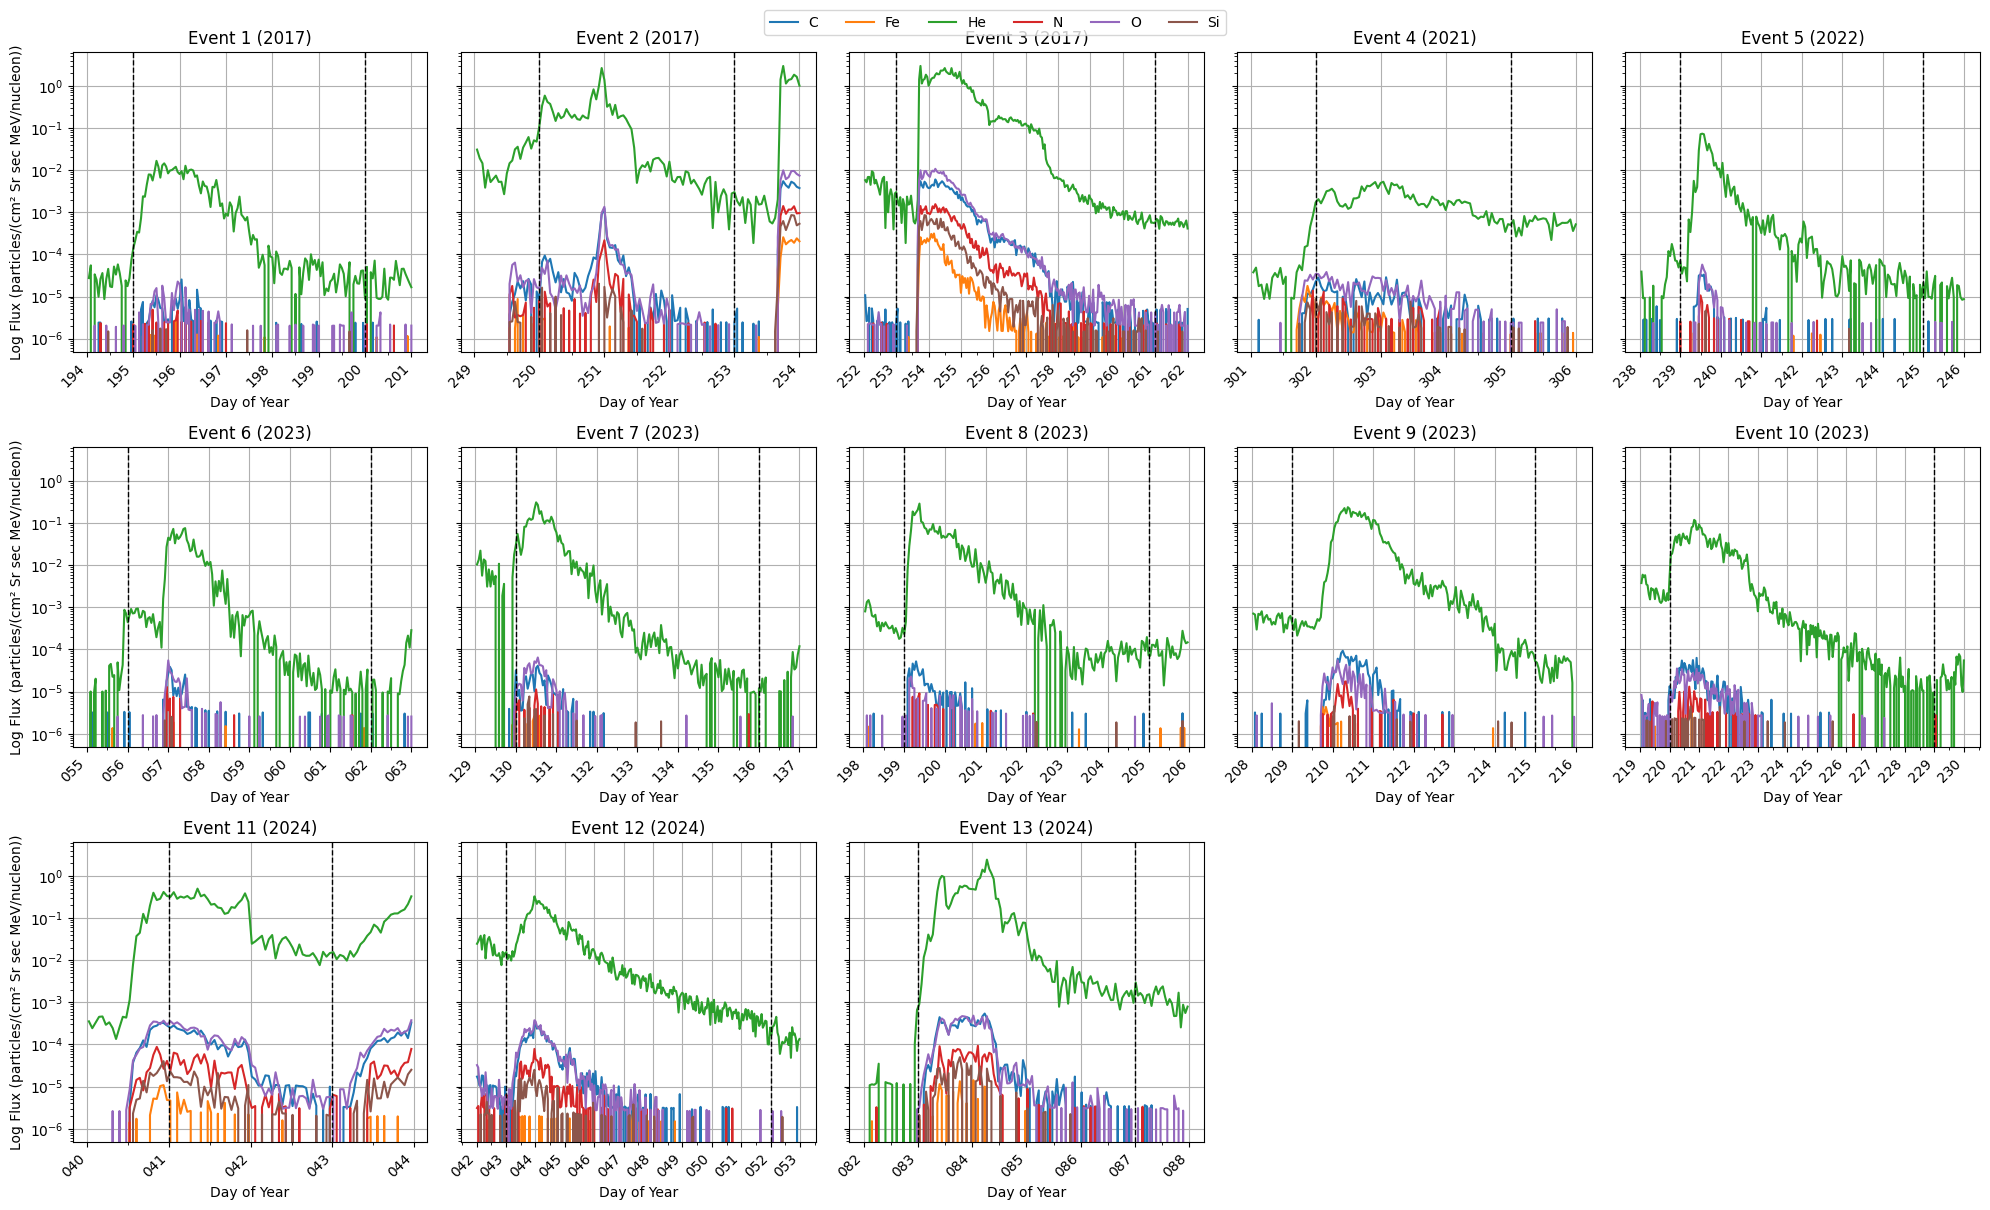

In [8]:
import pandas as pd

indices_to_keep = [0, 2, 3, 9, 16, 21, 25, 26, 27, 29, 36, 37, 39]
filtered_df = cleaned_decay_events_df.iloc[indices_to_keep]
filtered_df.reset_index(drop=True, inplace=True)

print(filtered_df)
plot_all_decay_events(filtered_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, useLogScale)


    Event Number  Start Year  End Year  Start Fractional Day  End Fractional Day  Start Hour  End Hour 
0          5         2017       2017          31.874988            34.083333       20.999722   2.000000
1        154         2023       2023         256.333333           259.208322        8.000000   4.999722
2        105         2022       2022         325.833333           329.541667       20.000000  13.000000
3          4         2017       2017         145.074135           149.242746       13.019102   7.487780
4          5         2022       2022         155.878208           159.844575       21.517789   2.154850
5          6         2018       2018         294.687341           298.957062       14.716809  14.254277
6          7         2019       2019         213.568054           214.605559       23.562730   5.913545
7          8         2018       2018          41.891049            46.869243       10.630962   7.347203
8          9         2019       2019         108.505819         

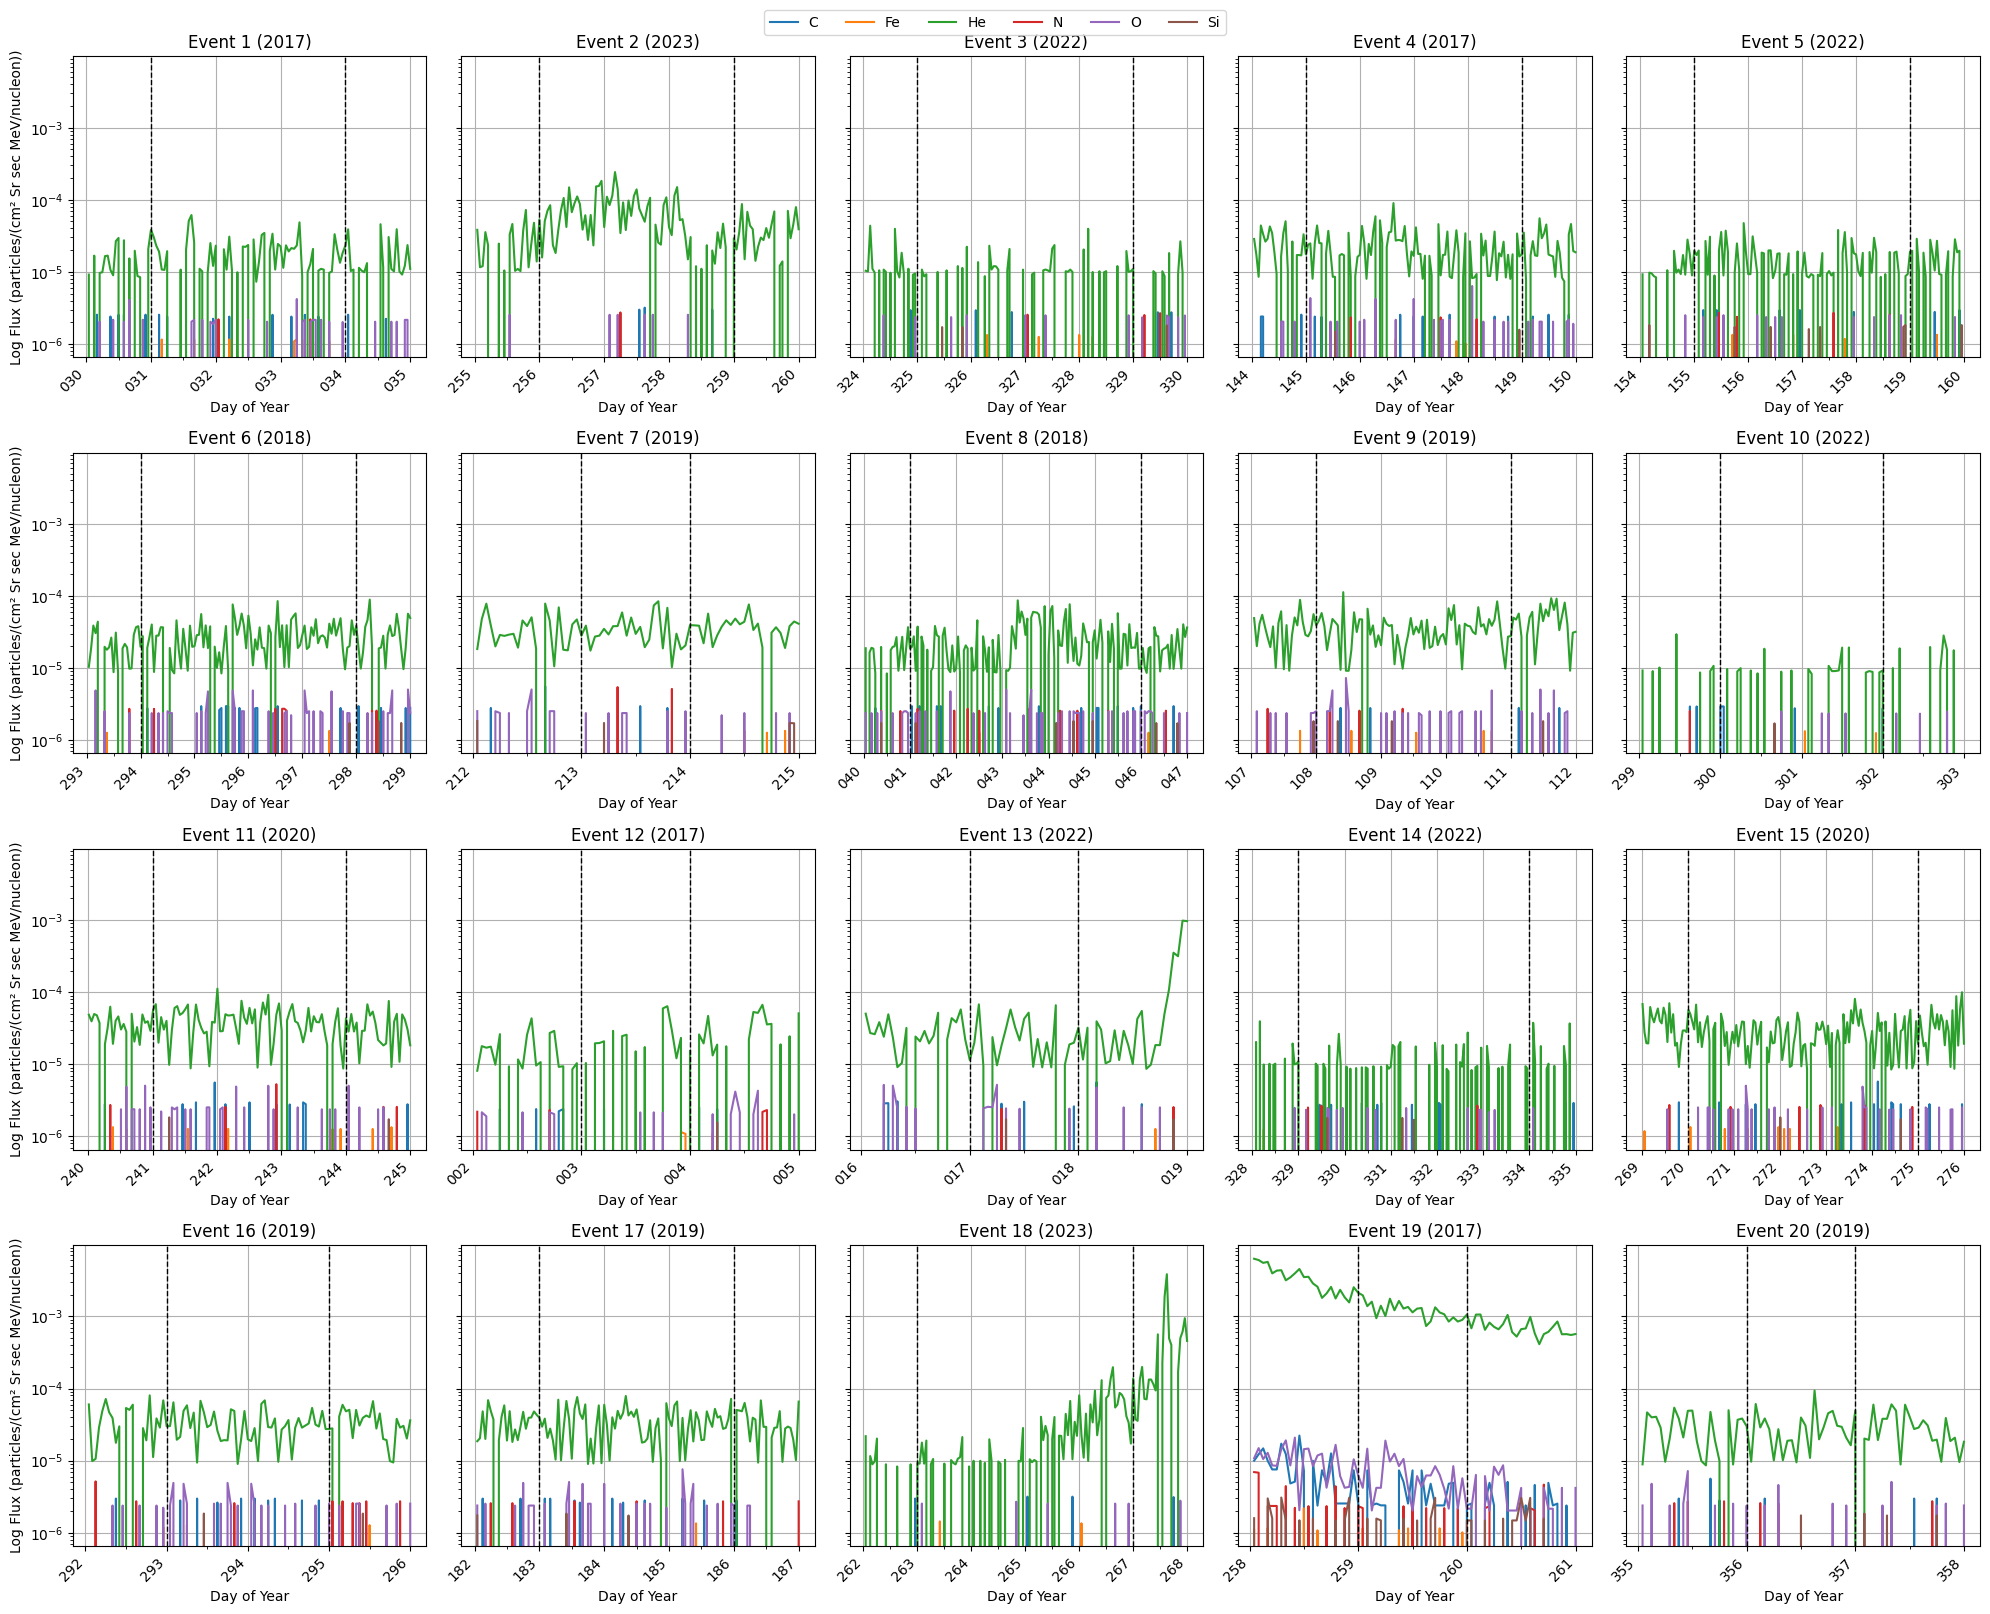

In [16]:
import pandas as pd
import numpy as np
import random

def generate_random_event_times(num_events=13, start_year=2017, end_year=2024):
    """Generates a dataframe with random event times between start_year and end_year."""
    data = {
        "Event Number": [],
        "Start Year": [],
        "End Year": [],
        "Start Fractional Day": [],
        "End Fractional Day": [],
        "Start Hour": [],
        "End Hour": [],
    }
    
    # Specific data for the first 3 events
    specific_data = [
        {"Event Number": 5, "Start Year": 2017, "End Year": 2017, "Start Fractional Day": 31.874988, "End Fractional Day": 34.083333, "Start Hour": 20.999722, "End Hour": 2.000000},
        {"Event Number": 154, "Start Year": 2023, "End Year": 2023, "Start Fractional Day": 256.333333, "End Fractional Day": 259.208322, "Start Hour": 8.000000, "End Hour": 4.999722},
        {"Event Number": 105, "Start Year": 2022, "End Year": 2022, "Start Fractional Day": 325.833333, "End Fractional Day": 329.541667, "Start Hour": 20.000000, "End Hour": 13.000000},
    ]
    
    # Add specific data for the first 3 events
    for event_data in specific_data[:3]:
        data["Event Number"].append(event_data["Event Number"])
        data["Start Year"].append(event_data["Start Year"])
        data["End Year"].append(event_data["End Year"])
        data["Start Fractional Day"].append(event_data["Start Fractional Day"])
        data["End Fractional Day"].append(event_data["End Fractional Day"])
        data["Start Hour"].append(event_data["Start Hour"])
        data["End Hour"].append(event_data["End Hour"])
    
    # Generate random data for the remaining events
    for event_number in range(4, num_events + 1):
        start_year_random = random.randint(start_year, end_year)
        end_year_random = start_year_random
        
        start_day_of_year = random.uniform(1, 365)
        
        # Ensure end day of year is within the range and greater than start_day_of_year
        max_duration_days = random.uniform(1, 120/24)  # Convert hours to days for range
        end_day_of_year = start_day_of_year + max_duration_days
        
        # Ensure end day of year does not exceed 365
        end_day_of_year = min(end_day_of_year, 365)
        
        start_hour = random.uniform(0, 24)
        end_hour = random.uniform(0, 24)
        
        data["Event Number"].append(event_number)
        data["Start Year"].append(start_year_random)
        data["End Year"].append(end_year_random)
        data["Start Fractional Day"].append(start_day_of_year)
        data["End Fractional Day"].append(end_day_of_year)
        data["Start Hour"].append(start_hour)
        data["End Hour"].append(end_hour)
    
    bad_df = pd.DataFrame(data)
    return bad_df

bad_df = generate_random_event_times(num_events=20)
print(bad_df)
plot_all_decay_events(bad_df, all_flux_data, datetime_values, element_mapping, energy_level_to_plot, extend_days, useLogScale)



In [17]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

def calculate_features(flux_values):
    """Calculates features from a list of flux values."""
    duration = len(flux_values)  # Assuming flux values are hourly
    max_flux = np.nanmax(flux_values)
    
    if (duration >= 25):
        initial_decay_rate = (flux_values[0] - flux_values[24]) / 24
        average_decay_rate = (flux_values[0] - flux_values[-1]) / duration
    else:
        initial_decay_rate = np.nan
        average_decay_rate = np.nan

    time_to_peak = np.argmax(flux_values)
    
    peaks, _ = find_peaks(flux_values)
    peak_prominence = (
        np.nanmax(flux_values[peaks]) - np.nanmin(flux_values) if peaks.size > 0 else 0
    )
    
    num_peaks = len(peaks)
    auc = np.trapz(flux_values)
    skewness = skew(flux_values, nan_policy="omit")
    kurt = kurtosis(flux_values, nan_policy="omit")

    std_flux = np.nanstd(flux_values)
    median_flux = np.nanmedian(flux_values)
    max_median_ratio = max_flux / median_flux if median_flux != 0 else np.nan
    normalized_time_to_peak = time_to_peak / duration if duration > 0 else np.nan

    decay_25_percent = (
        (flux_values[0] - flux_values[int(0.25 * duration)]) / (0.25 * duration)
        if duration >= 4
        else np.nan
    )
    decay_50_percent = (
        (flux_values[0] - flux_values[int(0.50 * duration)]) / (0.50 * duration)
        if duration >= 2
        else np.nan
    )
    decay_75_percent = (
        (flux_values[0] - flux_values[int(0.75 * duration)]) / (0.75 * duration)
        if duration >= 4
        else np.nan
    )
    avg_decay_percentages = np.nanmean(
        [decay_25_percent, decay_50_percent, decay_75_percent]
    )

    return (
        duration,
        max_flux,
        initial_decay_rate,
        average_decay_rate,
        time_to_peak,
        peak_prominence,
        num_peaks,
        auc,
        skewness,
        kurt,
        std_flux,
        median_flux,
        max_median_ratio,
        normalized_time_to_peak,
        decay_25_percent,
        decay_50_percent,
        decay_75_percent,
        avg_decay_percentages,
    )

def create_dataframe(filtered_df, datetime_values, all_flux_data, element_mapping, target_label):
    """Creates a dataframe from the given filtered dataframe and other data."""
    ml_data = []
    for i, row in filtered_df.iterrows():
        event_id = row["Event Number"]
        start_time = pd.to_datetime(
            f"{int(row['Start Year'])}-{row['Start Fractional Day']:.5f}", format="%Y-%j.%f"
        )
        end_time = pd.to_datetime(
            f"{int(row['End Year'])}-{row['End Fractional Day']:.5f}", format="%Y-%j.%f"
        )
        time_mask = (datetime_values >= start_time) & (datetime_values <= end_time)

        data_3d = np.where(all_flux_data == -999.9, np.nan, all_flux_data)

        for element_name, element_index in element_mapping.items():
            for energy_level in range(4):
                flux_values = data_3d[energy_level, time_mask, element_index]

                (
                    duration,
                    max_flux,
                    initial_decay_rate,
                    average_decay_rate,
                    time_to_peak,
                    peak_prominence,
                    num_peaks,
                    auc,
                    skewness,
                    kurt,
                    std_flux,
                    median_flux,
                    max_median_ratio,
                    normalized_time_to_peak,
                    decay_25_percent,
                    decay_50_percent,
                    decay_75_percent,
                    avg_decay_percentages,
                ) = calculate_features(flux_values)

                ml_data.append(
                    {
                        # "Event ID": event_id,
                        # "Element": element_name,
                        # "Energy Level": energy_level + 1,
                        "Duration": duration,
                        "Max Flux": max_flux,
                        "Initial Decay Rate": initial_decay_rate,
                        "Average Decay Rate": average_decay_rate,
                        "Time to Peak": time_to_peak,
                        "Peak Prominence": peak_prominence,
                        #"Number of Peaks": num_peaks,
                        #"AUC": auc,
                        "Skewness": skewness,
                        "Kurtosis": kurt,
                        "Std Flux": std_flux,
                        "Median Flux": median_flux,
                        "Max/Median Ratio": max_median_ratio,
                        "Normalized Time to Peak": normalized_time_to_peak,
                        "Decay Rate 25%": decay_25_percent,
                        "Decay Rate 50%": decay_50_percent,
                        "Decay Rate 75%": decay_75_percent,
                        "Avg Decay Percentages": avg_decay_percentages,
                        'Target Label': target_label
                    }
                )

    return pd.DataFrame(ml_data)

element_energy_decay_df = create_dataframe(filtered_df, datetime_values, all_flux_data, element_mapping, 1)
bad_element_energy_decay_df = create_dataframe(bad_df, datetime_values, all_flux_data, element_mapping, 0)

combined_df = pd.concat([element_energy_decay_df, bad_element_energy_decay_df], ignore_index=True)

# Shuffle the rows randomly
shuffled_indices = np.random.permutation(combined_df.index)
combined_df = combined_df.reindex(shuffled_indices).reset_index(drop=True)

combined_df.to_csv("out_csv/decay_input_features.csv", index=False)
print(combined_df)


     Duration  Max Flux  Initial Decay Rate  Average Decay Rate  Time to Peak  Peak Prominence  Skewness  Kurtosis     Std Flux    Median Flux  Max/Median Ratio  Normalized Time to Peak  Decay Rate 25%  Decay Rate 50%  Decay Rate 75%  Avg Decay Percentages  Target Label
0        48    0.000009       0.000000          0.000000e+00          35          0.000009      2.596162   4.750188  2.727423e-06    0.00000              NaN            0.729167           0.000000e+00    0.000000e+00    0.000000e+00       0.000000e+00             0     
1       144    0.000101      -0.000002          0.000000e+00          25          0.000101      3.429060  12.206507  1.742827e-05    0.00000              NaN            0.173611          -6.713611e-07    0.000000e+00    0.000000e+00      -2.237870e-07             1     
2       143    0.000297      -0.000003          0.000000e+00           8          0.000297      3.195876  10.797679  5.406584e-05    0.00000              NaN            0.055944          